In [2]:
# change the display more comfortable
import seaborn as sbn
sbn.set()

from IPython.display import HTML
CSS="""#notebook-container {
    width: 100%
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .input {
    width: 50%
}

.code_cell .output_wrapper {
    width: 50%
}"""
HTML('<style>{}</style>'.format(CSS))

In [3]:
# -*- coding: utf-8 -*-
__author__ = 'huangyf'

import os
import re
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from torch import nn, optim
from data_loader import get_loader
from torchvision import transforms
from models import vgg
from utils import AverageMeter, accuracy, get_margin, ramp_loss, margin_error, get_Lip

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

use_gpu = torch.cuda.is_available()


def train_model(model, criterion, optimizer, log_saver, g0, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'train1', 'test']:

            margin = []
            loss_meter = AverageMeter()
            rloss_meter = AverageMeter()
            ramp_loss_meter = AverageMeter()
            acc_meter = AverageMeter()
            margin_error_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[re.findall('[a-zA-Z]+',
                                                        phase)[0]]):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1

                N = outputs.size(0)

                margin = np.append(margin, get_margin(outputs, labels))
                loss_meter.update(loss.data.item(), N)
                acc_meter.update(
                    accuracy(outputs.data, labels.data)[-1].item(), N)

                if phase != 'train':
                    gamma = log_saver['Lip'][-1] * g0
                    ramp_loss_meter.update(
                        ramp_loss(get_margin(outputs, labels), gamma), N)
                    rloss_meter.update(
                        criterion(outputs / log_saver['Lip'][-1],
                                  labels).data.item(), N)
                    margin_error_meter.update(
                        margin_error(get_margin(outputs, labels), gamma), N)

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':
                model.eval()
                log_saver['Lip'].append(get_Lip(model,'vgg16'))

            if phase == 'train1':

                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)
                log_saver['margin_train'].append(margin)
                log_saver['train_rloss'].append(rloss_meter.avg)
                log_saver['train_ramp_loss'].append(ramp_loss_meter.avg)
                log_saver['train_margin_error'].append(margin_error_meter.avg)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)
                log_saver['margin_test'].append(margin)
                log_saver['test_rloss'].append(rloss_meter.avg)
                log_saver['test_ramp_loss'].append(ramp_loss_meter.avg)
                log_saver['test_margin_error'].append(margin_error_meter.avg)

            if phase != 'train':
                print(
                    f'{phase} Loss: {epoch_loss:.4f} rLoss: {rloss_meter.avg:.4f} Error: {epoch_error:.4f}',
                    f'RampLoss: {ramp_loss_meter.avg:.6f} MarginError: {margin_error_meter.avg:.4f}',
                    f"Margin: {min(margin):.4f} Lip: {log_saver['Lip'][-1]:.4e}"
                )

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {'net': model, 'epoch': epoch, 'log': log_saver}

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state,
                       './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )

    return model, log_saver

/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [28]:
def plot(log, q, result_dir):
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        #plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    def get_qmargin(margins, q):
        q1 = int(len(margins[0]) * q)
        return [np.partition(margin, q1)[q1] for margin in margins]

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, r'Normalised Margin')
    fig7, ax7 = get_fig(7, r'Normalised qMargin(.8)')
    fig8, ax8 = get_fig(8, r'qMargin(.8)')
    fig9, ax9 = get_fig(9, r'Rademacher Complexity')
    fig10, ax10 = get_fig(10, r'train rloss and test rloss')
    fig11, ax11 = get_fig(11, r'train rloss and test error')
    fig12, ax12 = get_fig(12, r'rc and test error')
    fig13, ax13 = get_fig(13, r'rloss')
    fig14, ax14 = get_fig(14, r'ramp loss')
    fig15, ax15 = get_fig(15, r'margin error and test error')
    fig16, ax16 = get_fig(16, r'margin error')

    ax1.plot(log['train_loss'],'r', linewidth=3, label='training')
    ax1.plot(log['test_loss'],'b', linewidth=3, label='test')
    ax1.set_ylabel('loss',fontdict=fontdict)
    ax2.plot(log['train_error'],'r', linewidth=3, label='training')
    ax2.plot(log['test_error'],'b', linewidth=3, label='test')
    ax2.set_ylabel('error',fontdict=fontdict)
    ax4.plot(
        [min(x) for x in log['margin_train']],'r', linewidth=3, label='training')
    ax4.plot([min(x) for x in log['margin_test']],'b', linewidth=3, label='test')

    ax14.plot(log['train_ramp_loss'],'r', linewidth=3, label='training')
    ax14.plot(log['test_ramp_loss'],'b', linewidth=3, label='test')

    ax8.plot(
        get_qmargin(log['margin_train'], q),'r', linewidth=3, label='training')
    ax8.plot(get_qmargin(log['margin_test'], q),'b', linewidth=3, label='test')
    ax13.plot(log['train_rloss'],'r', linewidth=3, label='training')
    ax13.plot(log['test_rloss'],'b', linewidth=3, label='test')

    ax16.plot(log['train_margin_error'],'r', linewidth=3, label='training')
    ax16.plot(log['test_margin_error'],'b', linewidth=3, label='test')

    log['nMargin_train'] = np.array([min(x) for x in log['margin_train']
                                     ]) / np.array(log['Lip'])
    log['nMargin_test'] = np.array([min(x) for x in log['margin_test']
                                    ]) / np.array(log['Lip'])

    ax5.plot(log['nMargin_train'],'r', linewidth=3, label='training')
    ax5.plot(log['nMargin_test'],'b', linewidth=3, label='test')

    log['nqMargin_train'] = np.array(get_qmargin(log['margin_train'],
                                                 q)) / np.array(log['Lip'])
    log['nqMargin_test'] = np.array(get_qmargin(log['margin_test'],
                                                q)) / np.array(log['Lip'])

    ax7.plot(1/log['nqMargin_train']*1e4,'r', linewidth=3, label=r'$1/\hat{\rho}_{q^{\ast}}$')
    ax7.plot(log['test_error'],'b', linewidth=3, label='test error')
    ax7.set_ylim(0,1)
    x1=np.argmin(1/log['nqMargin_train'])
    x2=np.argmin(log['test_error'])
    ax7.plot([x1,x1],[0,1/log['nqMargin_train'][x1]*1e4],'r--')
    ax7.plot([x2,x2],[0,log['test_error'][x2]],'b--')
    ax7.set_xticks([0,min(x1,x2),max(x1,x2),20,40,60,80,100])

    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.3)),
        linewidth=3,
        label='q=0.3')
    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.5)),
        linewidth=3,
        label='q=0.5')
    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.8)),
        linewidth=3,
        label='q=0.8')

    ax10.scatter(
        log['train_rloss'],
        log['test_rloss'],
        label=
        f"corrcoef= {np.corrcoef(log['train_rloss'], log['test_rloss'])[0,1]:.4f}"
    )

    ax11.scatter(
        log['train_rloss'],
        log['test_error'],
        label=
        f"corrcoef= {np.corrcoef(log['train_rloss'], log['test_error'])[0,1]:.4f}"
    )

    log['RC'] = np.array(log['Lip']) / np.array(
        get_qmargin(log['margin_train'], q))
    ax12.scatter(
        log['RC'][10:],
        log['test_error'][10:],
        label=
        f"corrcoef= {np.corrcoef(log['RC'][10:], log['test_error'][10:])[0,1]:.4f}"
    )

    ax15.scatter(
        log['train_margin_error'],
        log['test_error'],
        label=
        f"corrcoef= {np.corrcoef(log['train_margin_error'], log['test_error'])[0,1]:.4f}"
    )

    for ax in [ax1, ax2, ax4, ax5, ax7, ax8, ax9, ax13, ax14, ax16]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    ax10.set_xlabel('train rloss', fontdict=fontdict)
    ax10.set_ylabel('test rloss', fontdict=fontdict)
    ax10.legend(loc='upper right', fontsize=20)

    ax11.set_xlabel('train rloss', fontdict=fontdict)
    ax11.set_ylabel('test error', fontdict=fontdict)
    ax11.legend(loc='upper right', fontsize=20)

    ax12.set_xlabel('train RC', fontdict=fontdict)
    ax12.set_ylabel('test error', fontdict=fontdict)
    ax12.legend(loc='upper right', fontsize=20)

    ax15.set_xlabel('train margin error', fontdict=fontdict)
    ax15.set_ylabel('test error', fontdict=fontdict)
    ax15.legend(loc='upper right', fontsize=20)

    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss.png')
    fig2.savefig(result_dir + 'error.png')
    fig4.savefig(result_dir + 'margin.png')
    fig5.savefig(result_dir + 'n_margin.png')
    fig7.savefig(result_dir + 'nq_margin.png')
    fig8.savefig(result_dir + 'q_margin.png')
    fig9.savefig(result_dir + 'rc.png')
    fig10.savefig(result_dir + 'rloss_rloss.png')
    fig11.savefig(result_dir + 'rloss_error.png')
    fig12.savefig(result_dir + 'rc_error.png')
    fig13.savefig(result_dir + 'rloss.png')
    fig14.savefig(result_dir + 'ramp_loss.png')
    fig15.savefig(result_dir + 'margin_error_test_error.png')
    fig16.savefig(result_dir + 'margin_error.png')

## Experiment on CIFAR10 with noise=0 for VGG16
The codes are similar to margin_resnet18.ipynb and margin_alex.ipynb

In [4]:
#
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
model = vgg.VGG('VGG16')

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: original ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 14728266


In [5]:
model, log = train_model(
    model, criterion, optimizer, log, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 0.8696 rLoss: 948.9580 Error: 0.3073 RampLoss: 0.307320 MarginError: 0.3073 Margin: -8.4550 Lip: 4.2695e-04
test Loss: 0.9521 rLoss: 1119.8093 Error: 0.3411 RampLoss: 0.341193 MarginError: 0.3413 Margin: -7.4499 Lip: 4.2695e-04
Saving..
Epoch 2/100
----------
train1 Loss: 0.6000 rLoss: 909.4245 Error: 0.2062 RampLoss: 0.206200 MarginError: 0.2062 Margin: -7.3372 Lip: 2.8384e-04
test Loss: 0.7518 rLoss: 1371.2564 Error: 0.2605 RampLoss: 0.260531 MarginError: 0.2606 Margin: -7.2703 Lip: 2.8384e-04
Epoch 3/100
----------
train1 Loss: 0.5093 rLoss: 977.9691 Error: 0.1767 RampLoss: 0.176694 MarginError: 0.1767 Margin: -8.0790 Lip: 2.5821e-04
test Loss: 0.7592 rLoss: 1846.7203 Error: 0.2575 RampLoss: 0.257535 MarginError: 0.2576 Margin: -9.6979 Lip: 2.5821e-04
Epoch 4/100
----------
train1 Loss: 0.3654 rLoss: 652.1276 Error: 0.1204 RampLoss: 0.120360 MarginError: 0.1204 Margin: -7.9727 Lip: 2.3581e-04
test Loss: 0.7048 rLoss: 1891.7518 Error: 0.2380 RampLo

In [6]:
import pickle
pickle.dump(log,open('./vgg16_results_original/log_original.log','wb'))

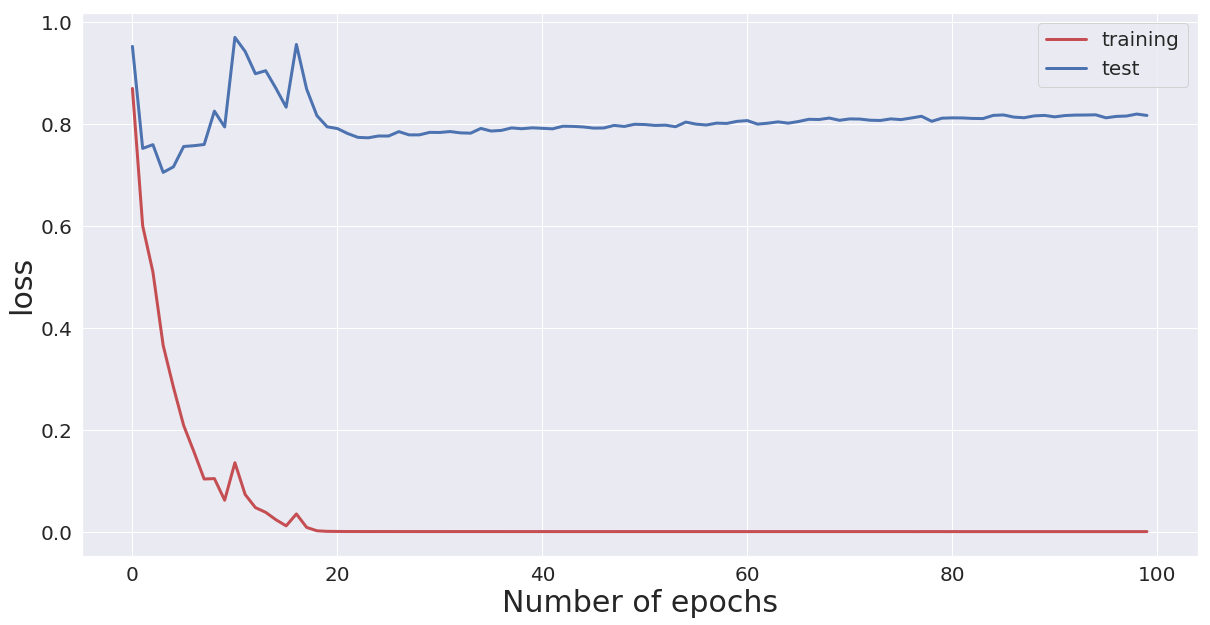

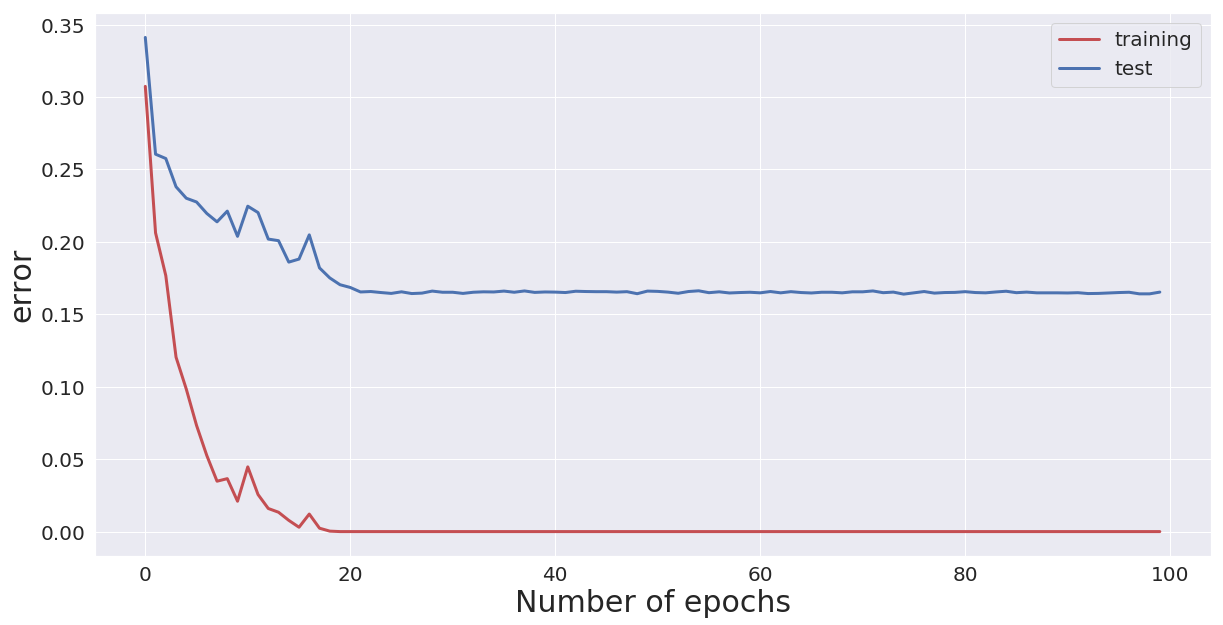

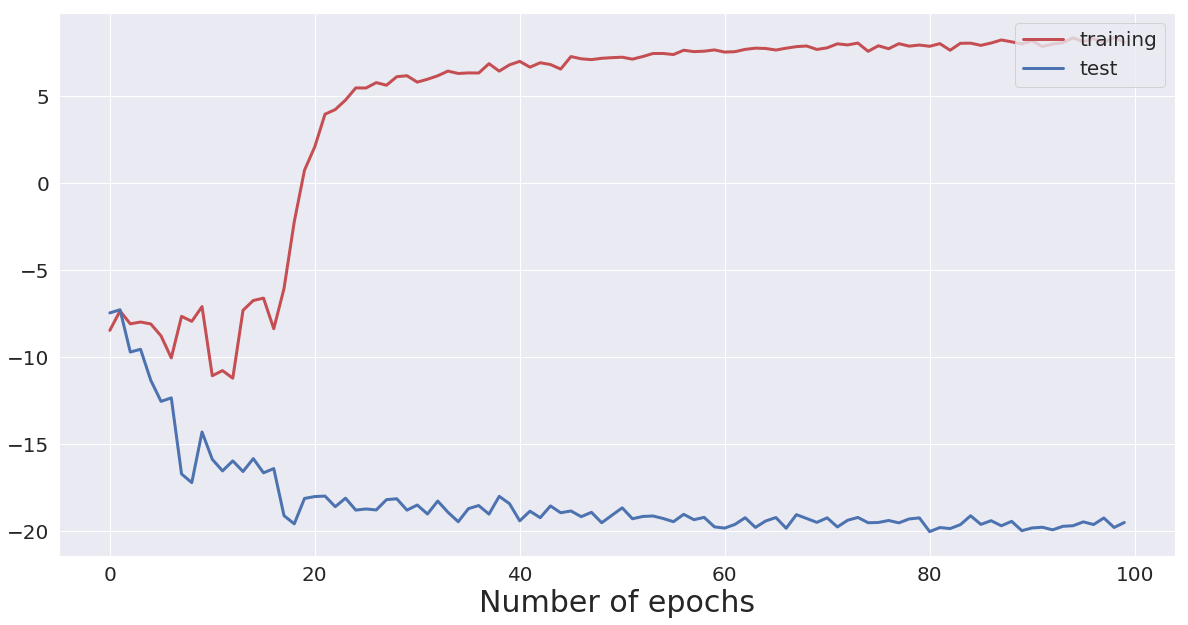

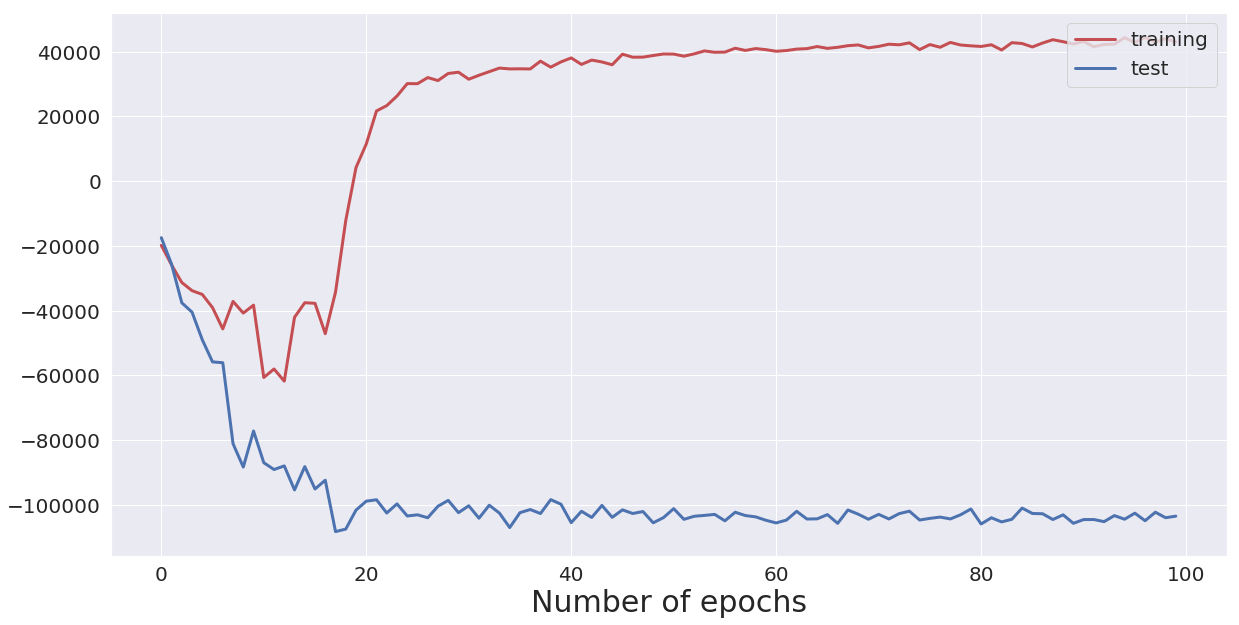

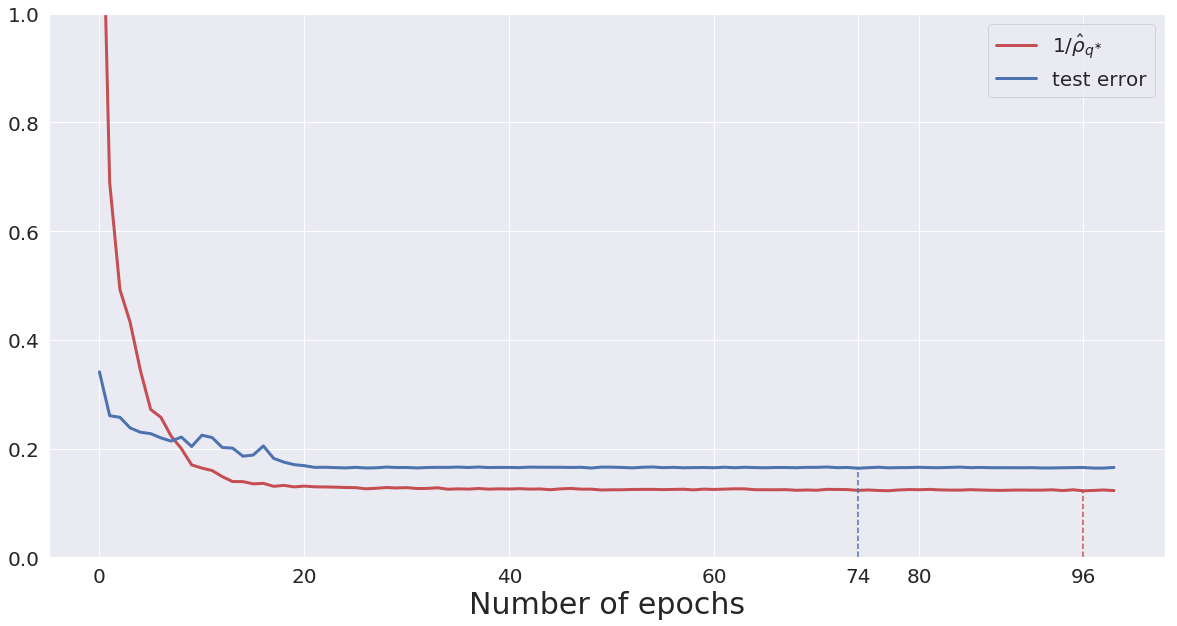

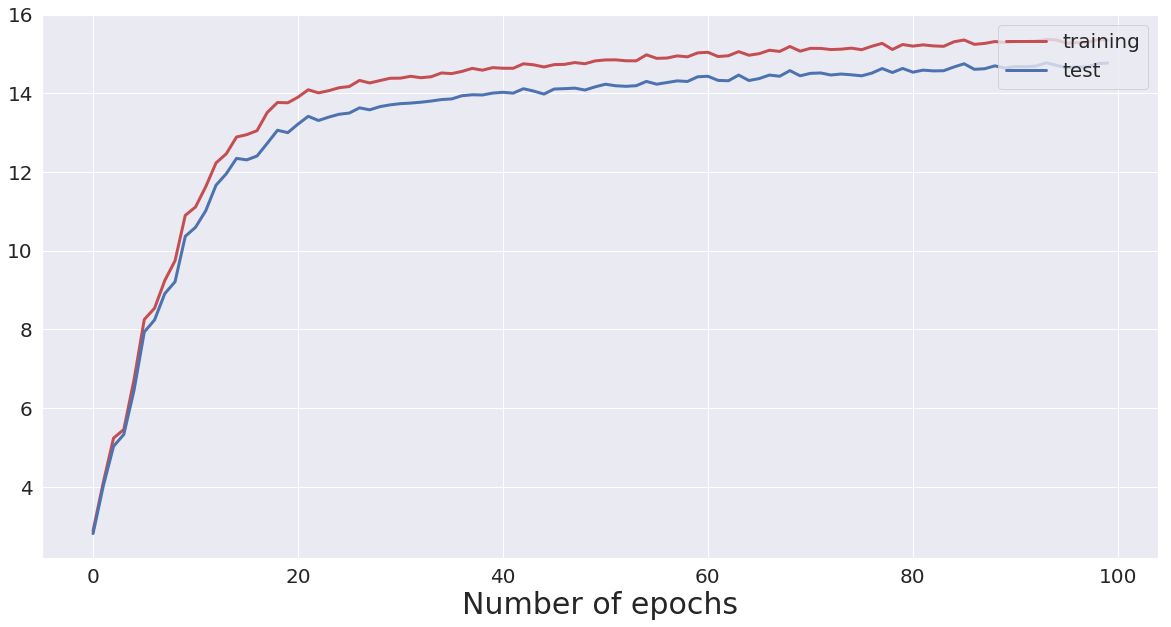

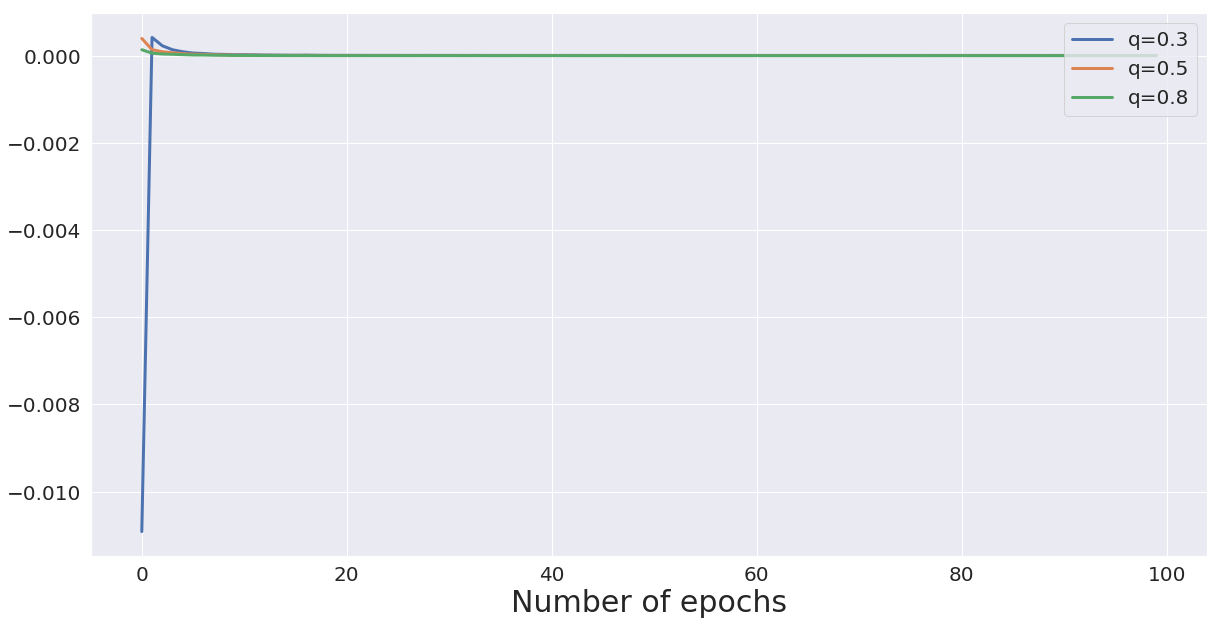

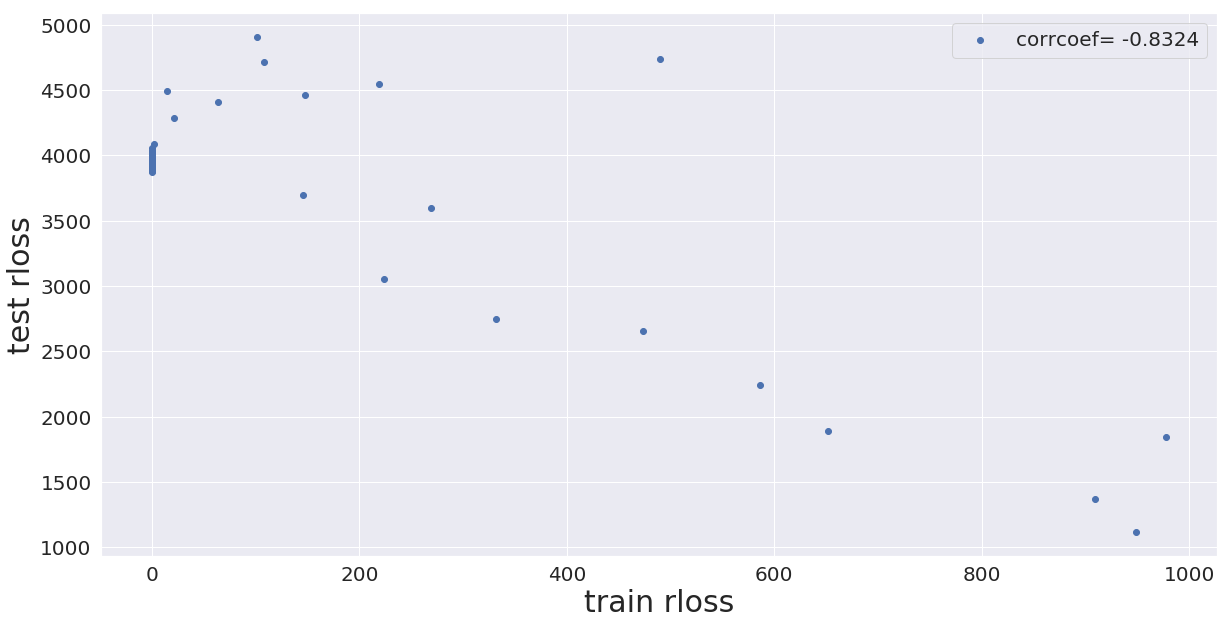

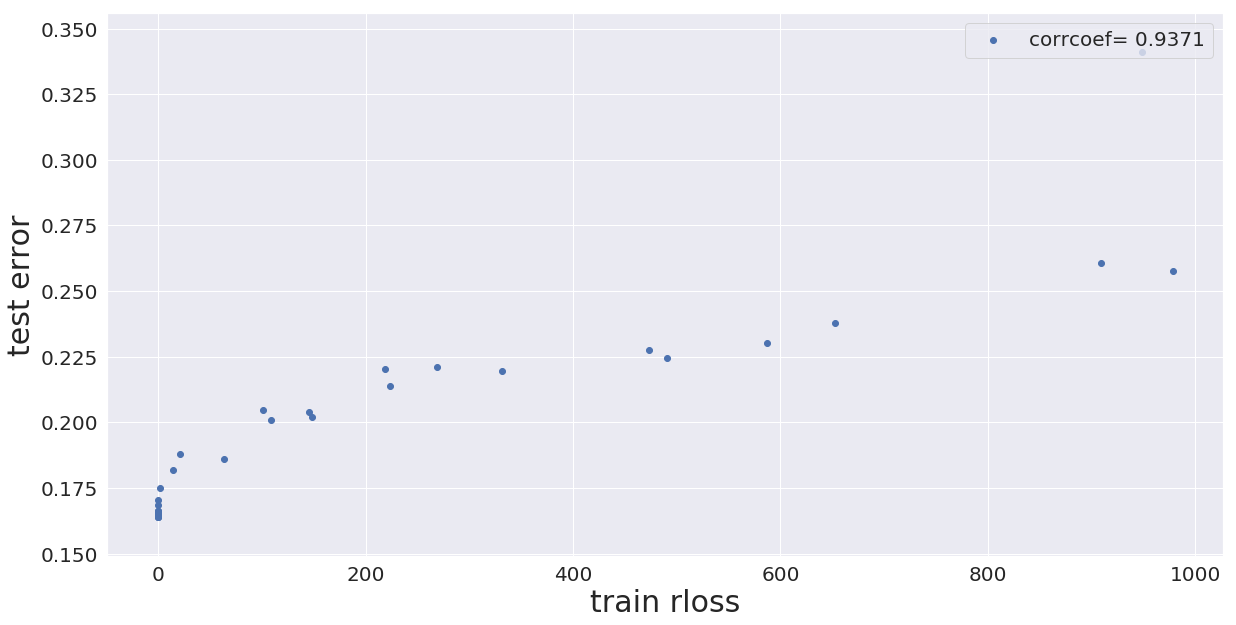

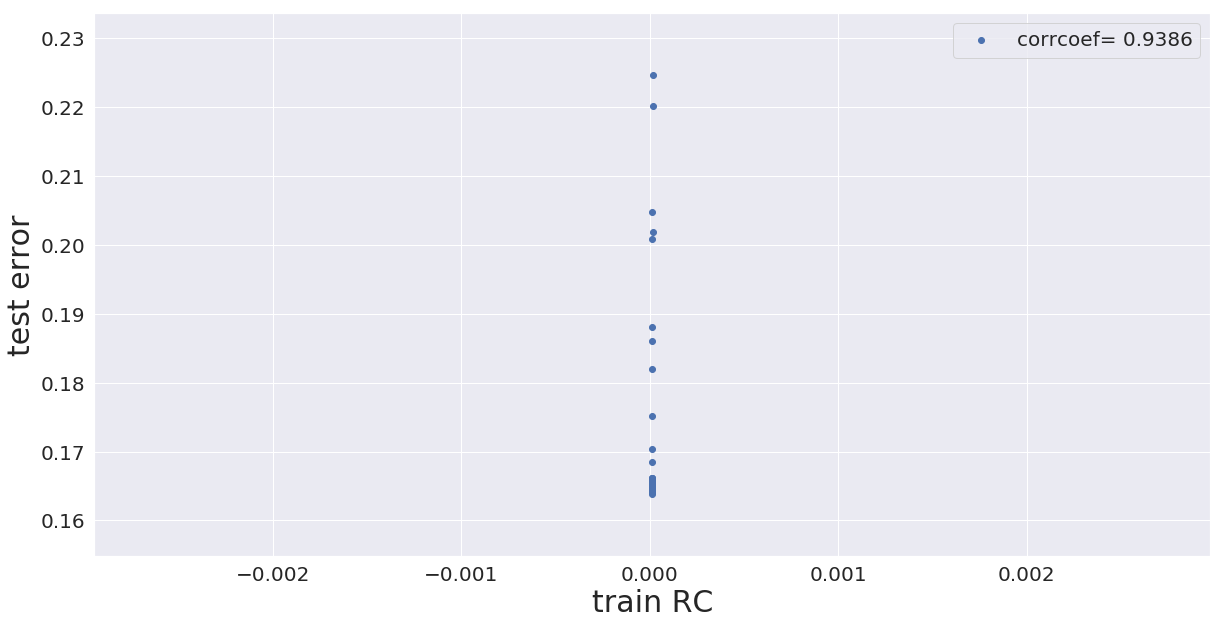

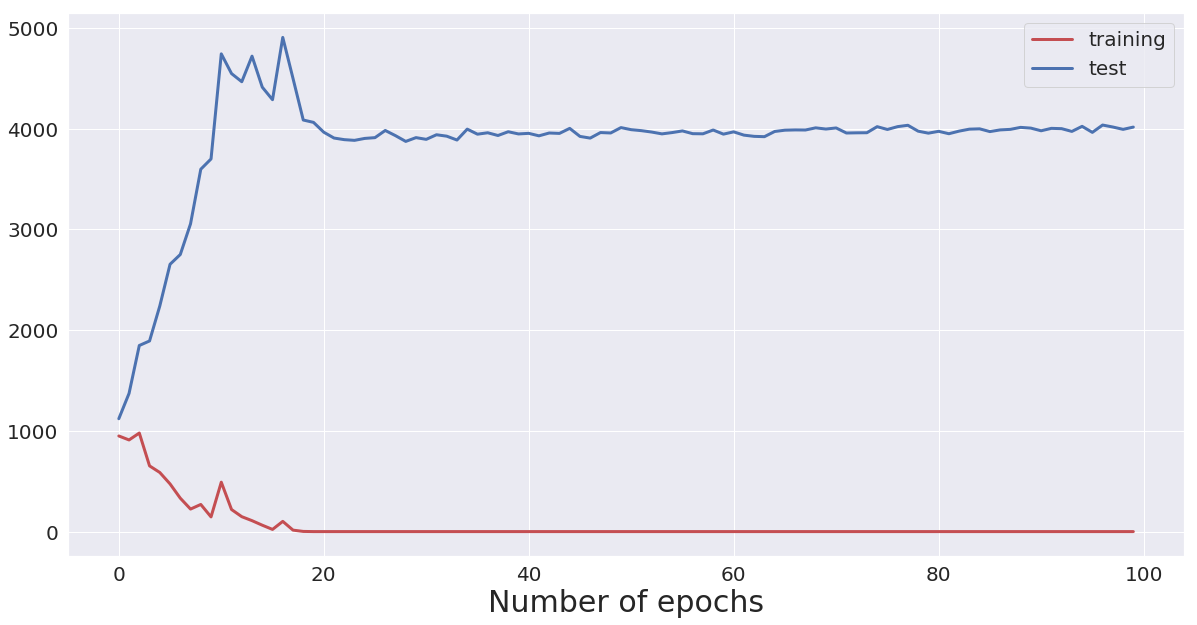

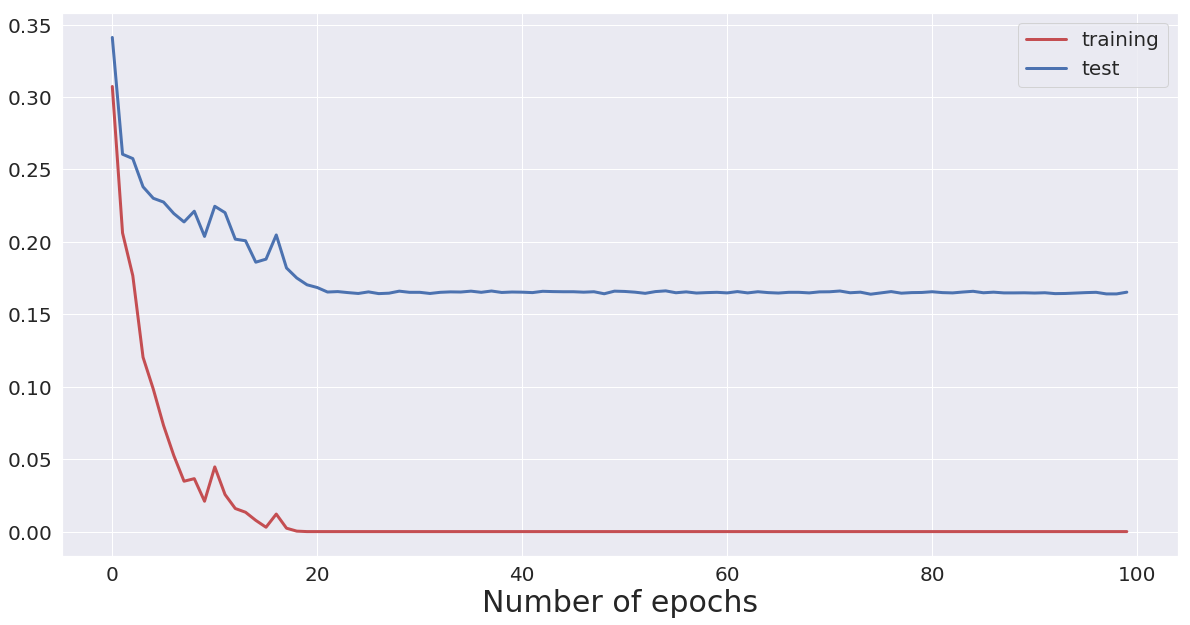

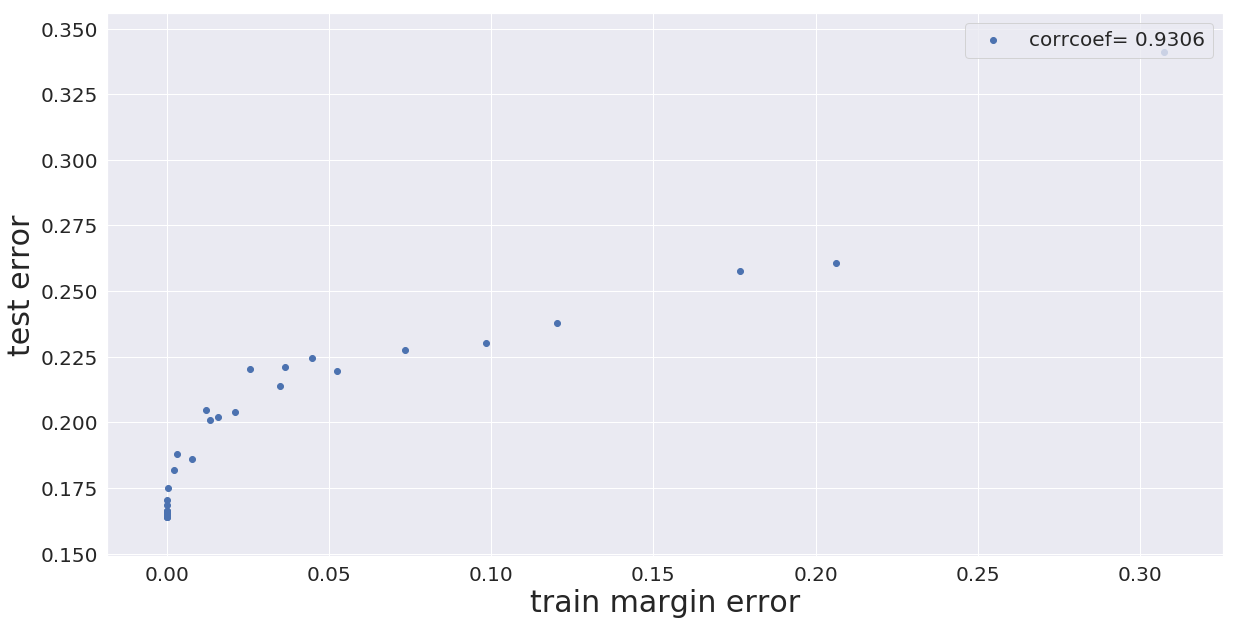

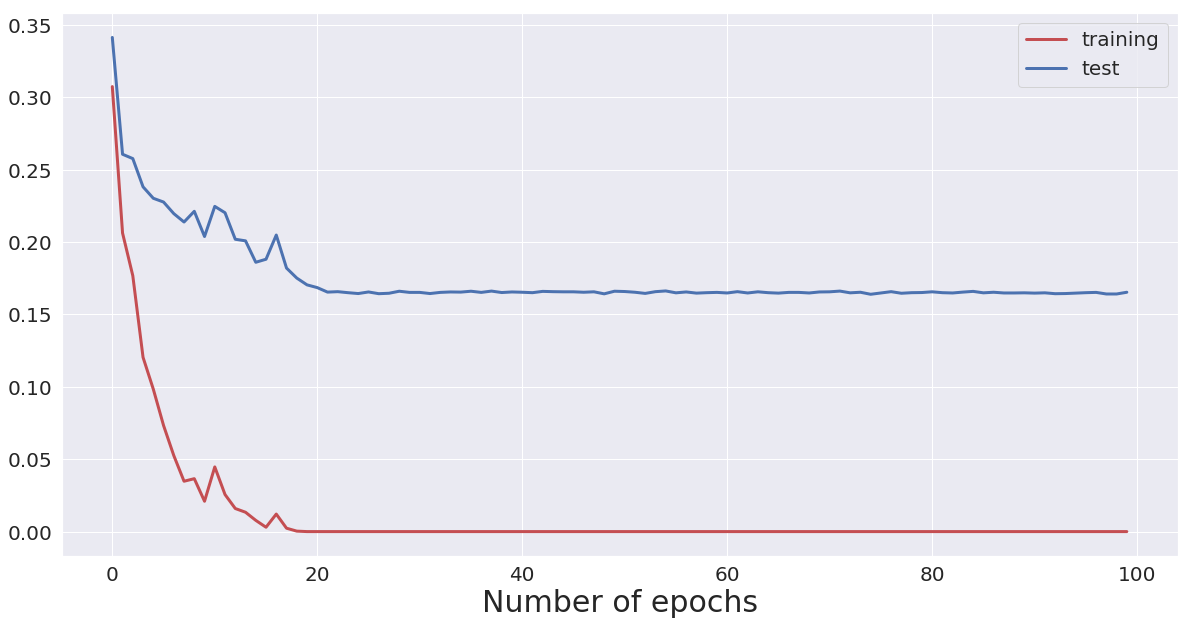

In [21]:
plot(log, 0.8, './vgg16_results_original/')
plt.show()

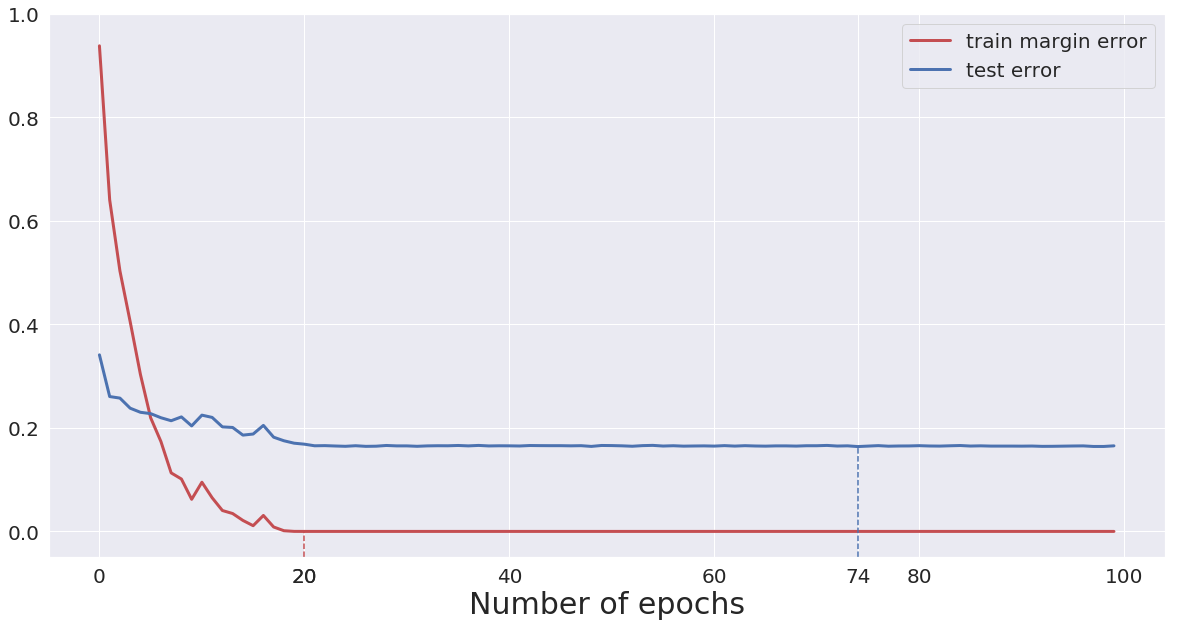

In [22]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 1e4) for (margin, lip) in zip(log['margin_train'], log['Lip'])]
ax.plot(train_merror
    ,'r',linewidth=3,
    label='train margin error')
ax.plot(log['test_error'],'b',linewidth=3,label='test error')
ax.legend(fontsize=20,loc='best')
#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
x1=np.argmin(log['test_error'])
ax.plot([x1,x1],[-0.05,log['test_error'][x1]],'b--')
x2=np.argmin(train_merror)
ax.plot([x2,x2],[-0.05,train_merror[x2]],'r--')
ax.set_xticks([0,min(x1,x2),max(x1,x2),20,40,60,80,100])
ax.set_xlabel('Number of epochs',fontdict={'size': 30})
fig.savefig('./vgg16_results_original/margin_error_and_test_error.png')

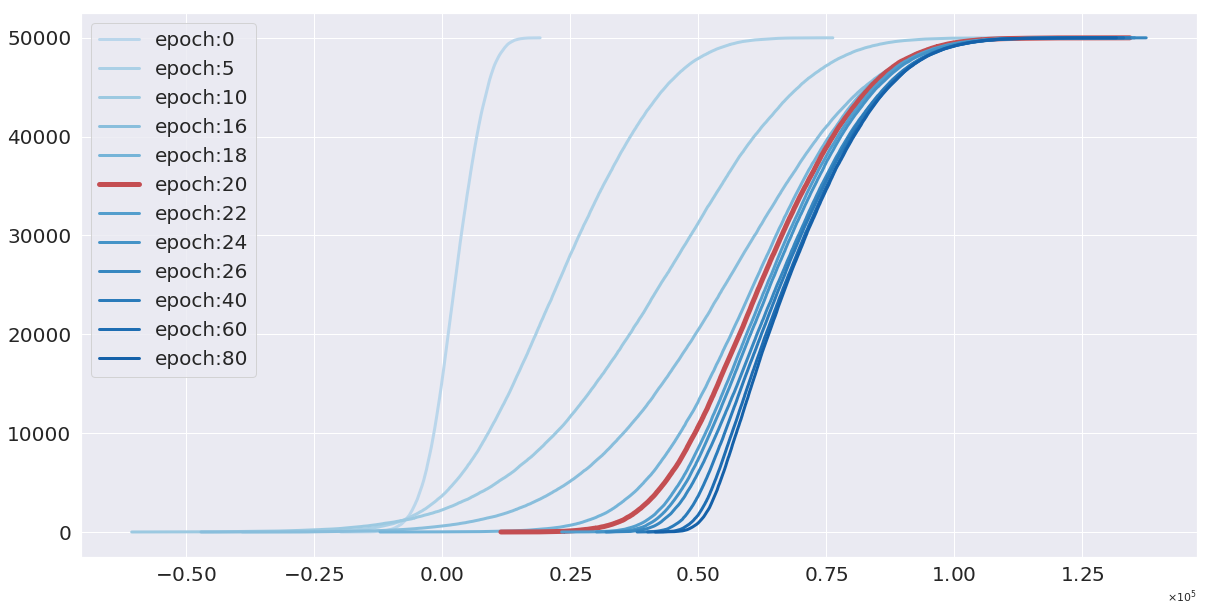

In [23]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,16,18,20,22,24,26,40,60, 80]):
    if i==20:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log['margin_train'][i])/log['Lip'][i], range(50000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./vgg16_results_original/'+'nMargin_distribution.png')

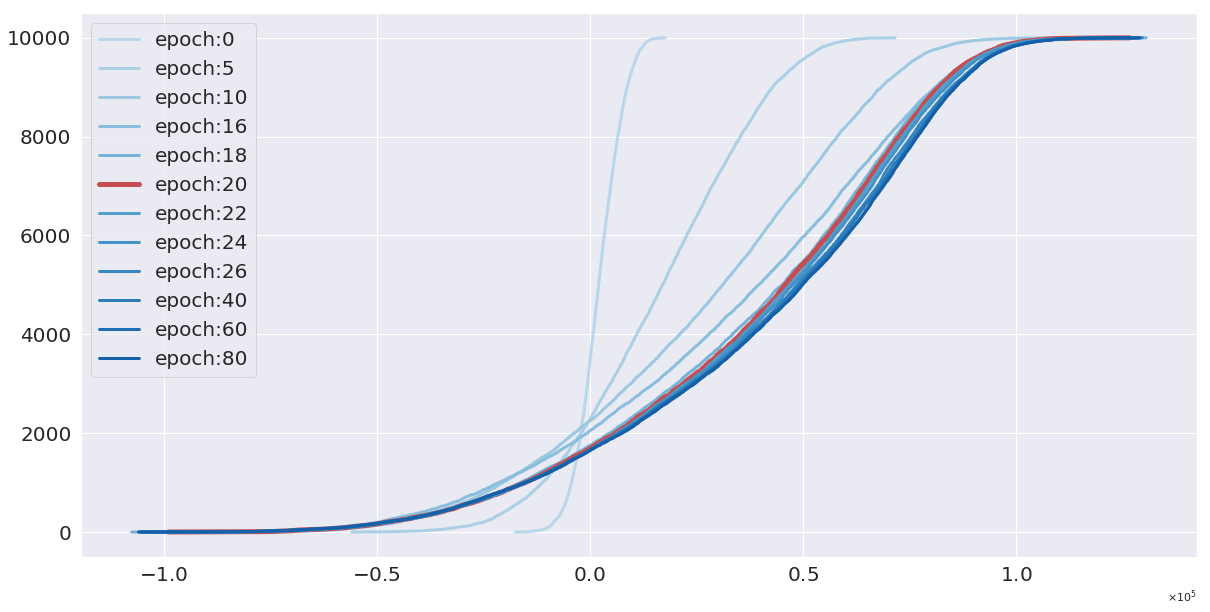

In [24]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,16,18,20,22,24,26,40,60, 80]):
    if i==20:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log['margin_test'][i])/log['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./vgg16_results_original/'+'test_nMargin_distribution.png')

In [44]:
def plot_heatmap(log,path,interval):
    n=len(interval)
    corr=np.zeros((n,n))
    corr_linear=np.zeros((n,n))
    for i in range(n):
        g1=interval[i]
        train_merror=[margin_error(margin, lip * g1) for (margin, lip) in zip(log['margin_train'], log['Lip'])]
        for j in range(n):
            g2=interval[j]
            test_merror=[margin_error(margin, lip * g2) for (margin, lip) in zip(log['margin_test'], log['Lip'])]
            corr[i,j]=scipy.stats.spearmanr(train_merror,test_merror)[0]
            corr_linear[i,j]=np.corrcoef(train_merror,test_merror)[0,1]
    fig = plt.figure(1, figsize=(20, 10))
    ax = fig.add_subplot(111)
    im=ax.pcolormesh(interval,interval,corr,vmin=-0.8,vmax=0.8)
    fig.colorbar(im)
    ax.axis('tight')
    ax.set_xlabel('$\gamma_{1}$',fontsize=20)
    ax.set_ylabel('$\gamma_{2}$',fontsize=20)
    from matplotlib import ticker
    formatter=ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    fig.savefig(path+'margin_error_rankcorr.png')
    plt.show()
    
    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)
    im=ax.pcolormesh(interval,interval,corr_linear)
    fig.colorbar(im)
    ax.axis('tight')
    from matplotlib import ticker
    formatter=ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    fig.savefig(path+'margin_error_linearcorr.png')
    plt.show()

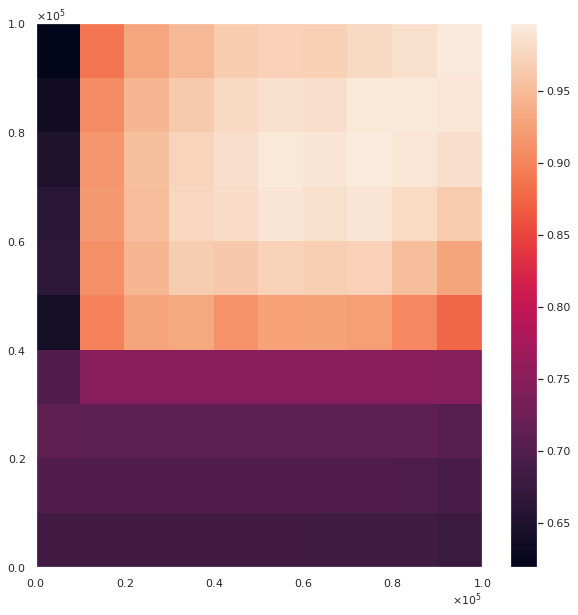

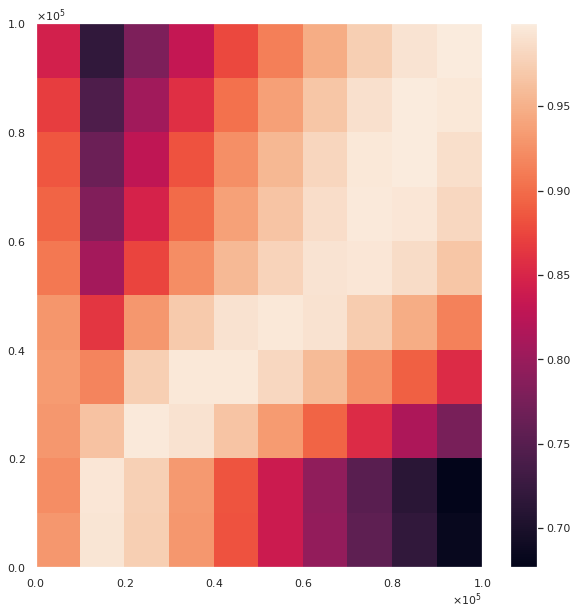

In [26]:
plot_heatmap(log,'./vgg16_results_original/',np.linspace(0,1e5,11))

## Experiment on CIFAR10 with noise=0.1 for VGG16

In [11]:
#
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log_1 = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
model = vgg.VGG('VGG16')

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_1['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 14728266


In [12]:
model, log_1 = train_model(
    model, criterion, optimizer, log_1, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 1.4499 rLoss: 1744.6422 Error: 0.4824 RampLoss: 0.482414 MarginError: 0.4825 Margin: -7.0964 Lip: 4.4696e-04
test Loss: 1.5354 rLoss: 1921.6721 Error: 0.5077 RampLoss: 0.507792 MarginError: 0.5078 Margin: -6.5506 Lip: 4.4696e-04
Saving..
Epoch 2/100
----------
train1 Loss: 1.0861 rLoss: 1911.6631 Error: 0.3346 RampLoss: 0.334612 MarginError: 0.3346 Margin: -8.3361 Lip: 3.2213e-04
test Loss: 1.2638 rLoss: 2401.7117 Error: 0.3874 RampLoss: 0.387433 MarginError: 0.3875 Margin: -7.9249 Lip: 3.2213e-04
Epoch 3/100
----------
train1 Loss: 0.9446 rLoss: 1959.1033 Error: 0.2781 RampLoss: 0.278089 MarginError: 0.2781 Margin: -8.2828 Lip: 2.7476e-04
test Loss: 1.2015 rLoss: 2799.3379 Error: 0.3584 RampLoss: 0.358400 MarginError: 0.3584 Margin: -7.7723 Lip: 2.7476e-04
Epoch 4/100
----------
train1 Loss: 0.7199 rLoss: 1413.6677 Error: 0.1928 RampLoss: 0.192850 MarginError: 0.1929 Margin: -7.6721 Lip: 2.6560e-04
test Loss: 1.0899 rLoss: 2609.4492 Error: 0.3154 Ra

In [14]:
import pickle
pickle.dump(log_1,open('./vgg16_results_p0.1/log_p0.1.log','wb'))

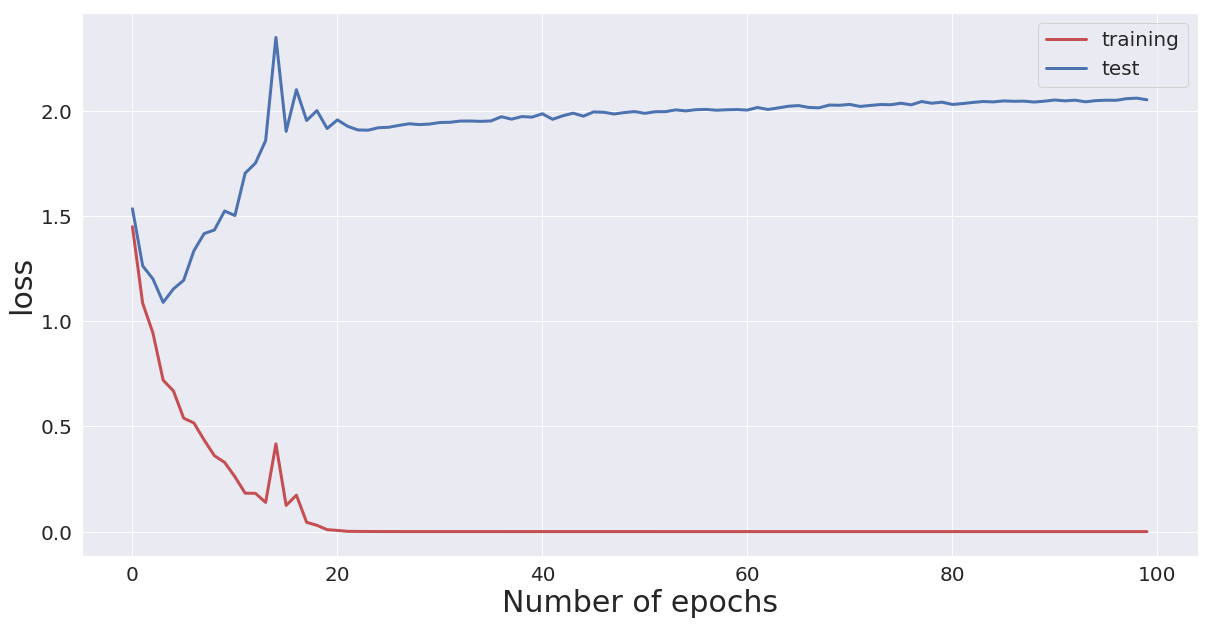

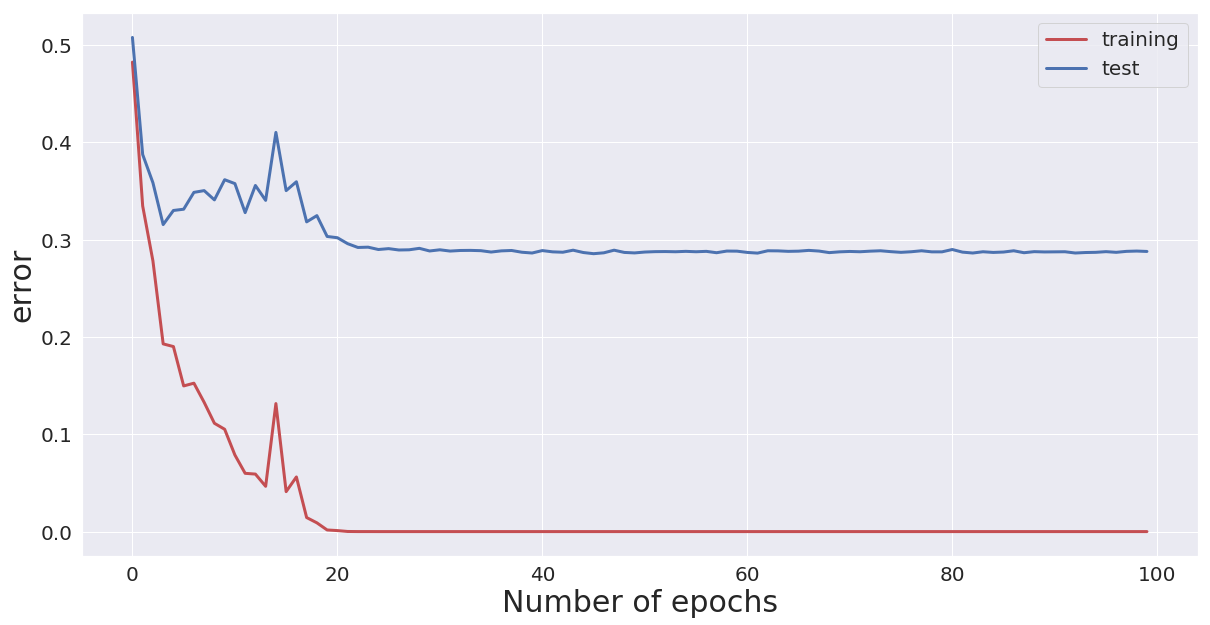

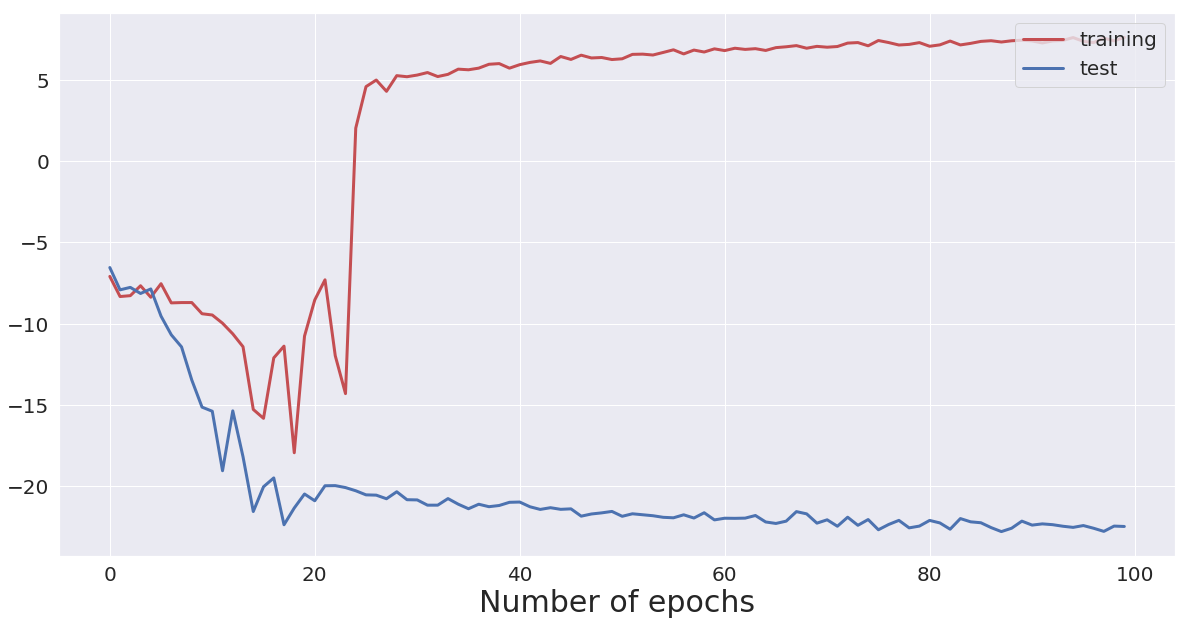

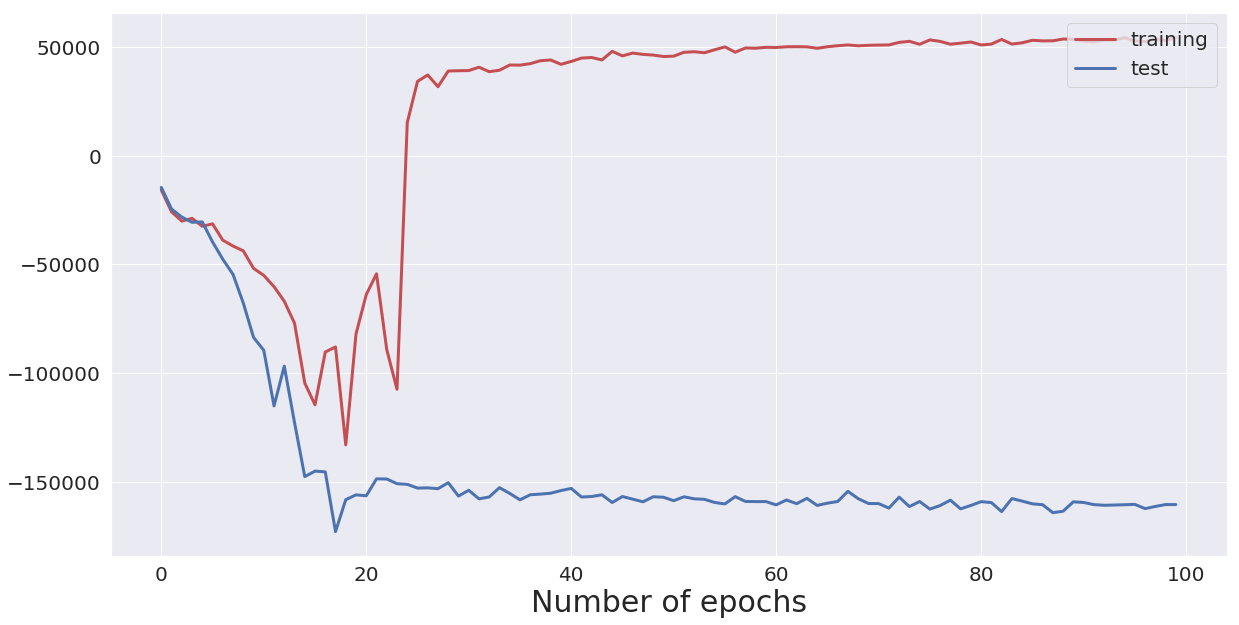

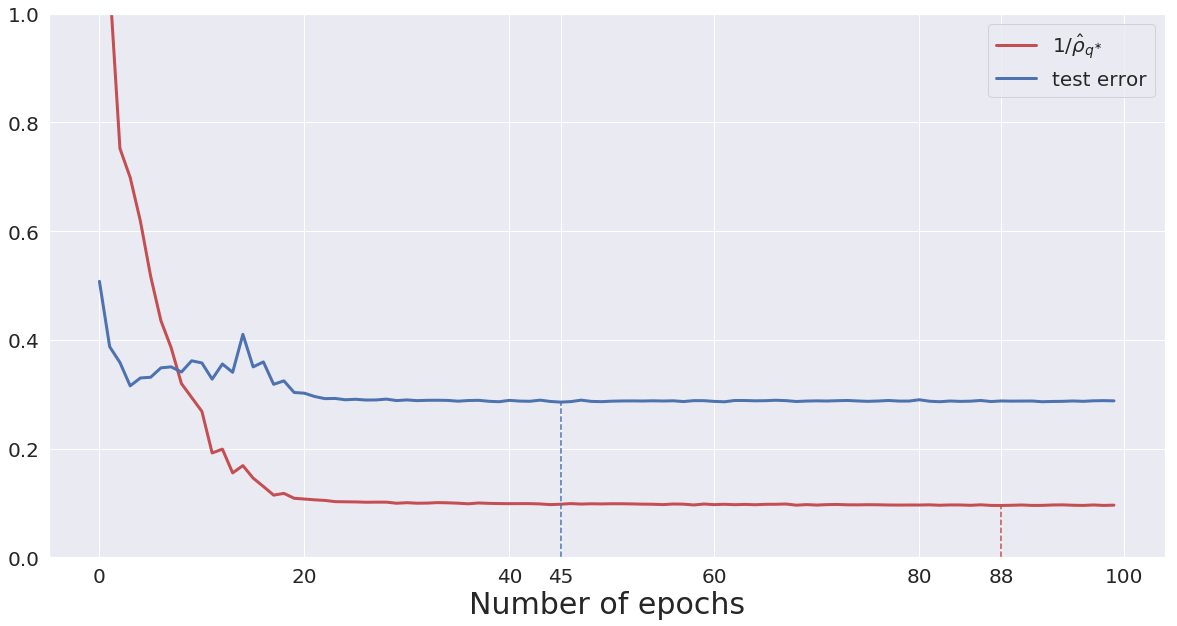

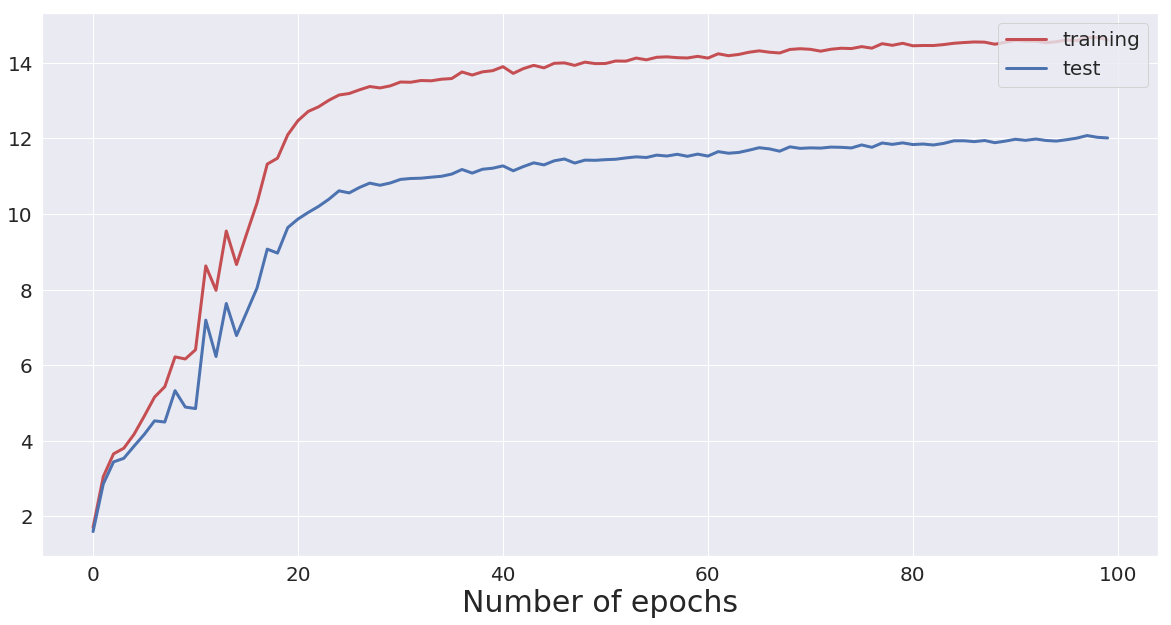

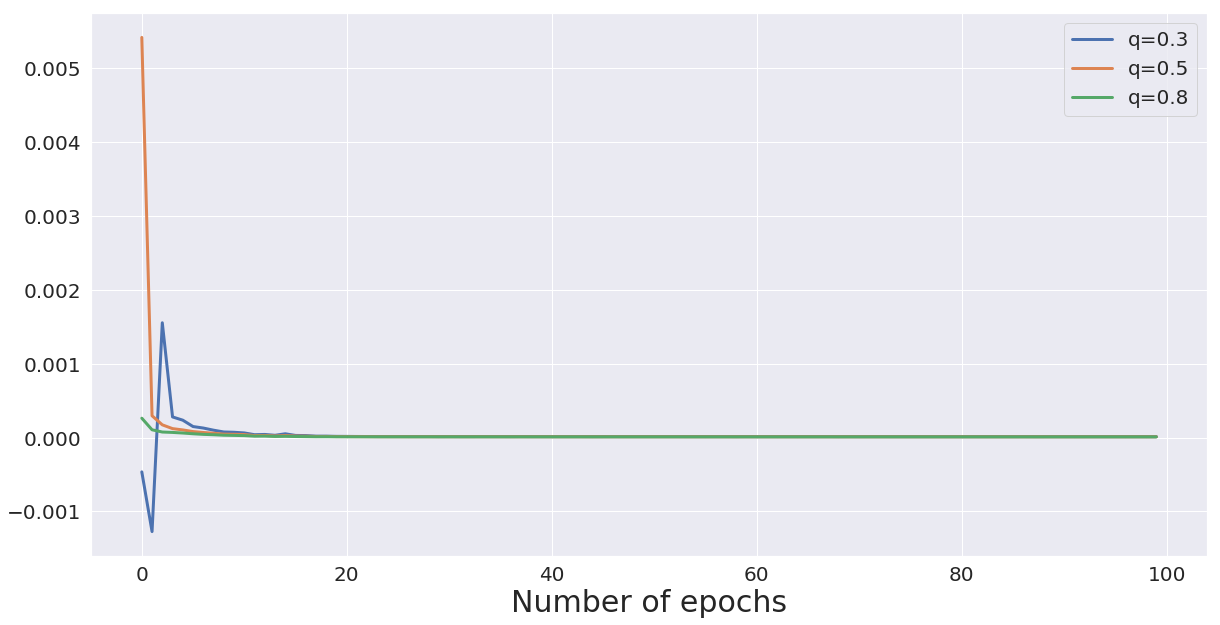

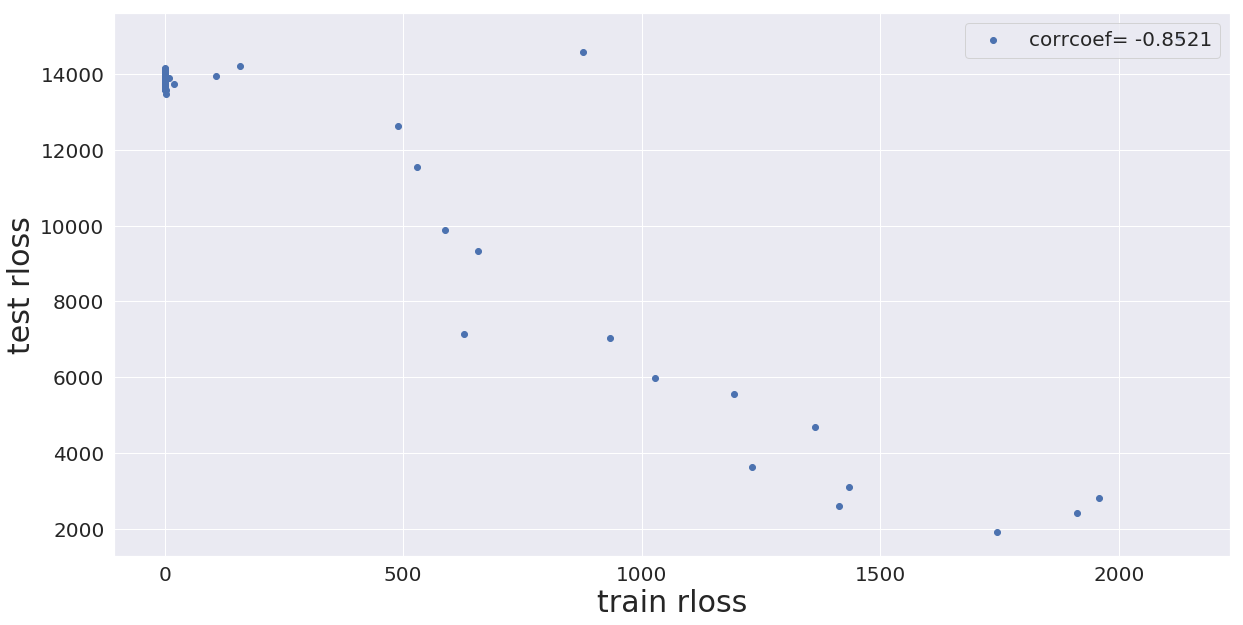

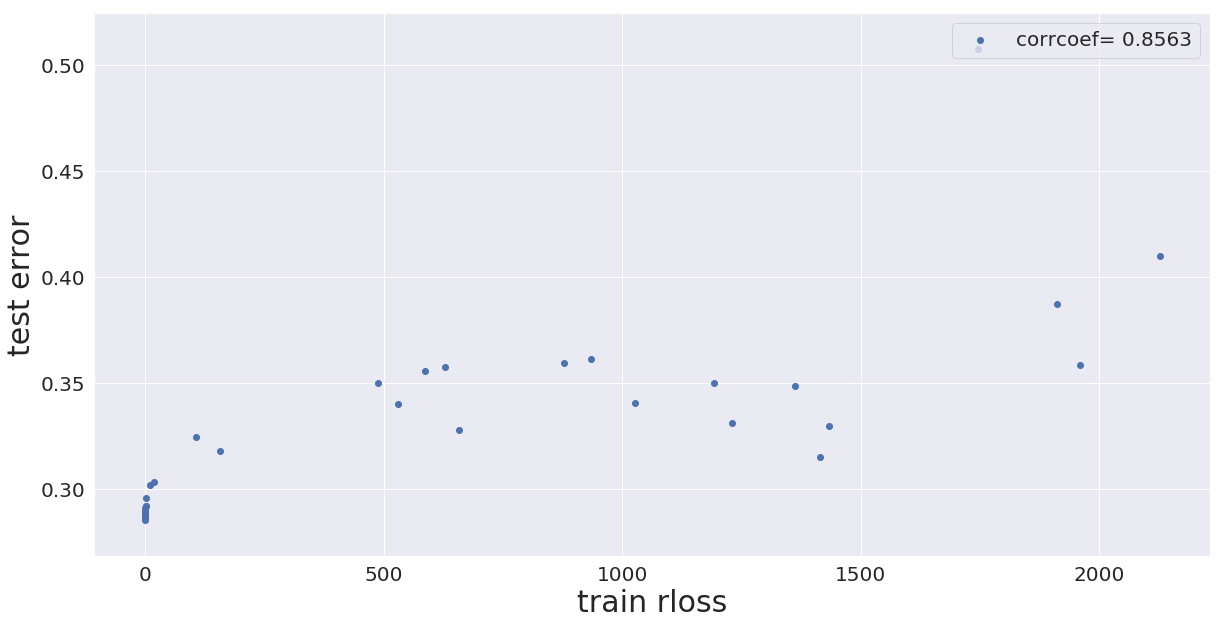

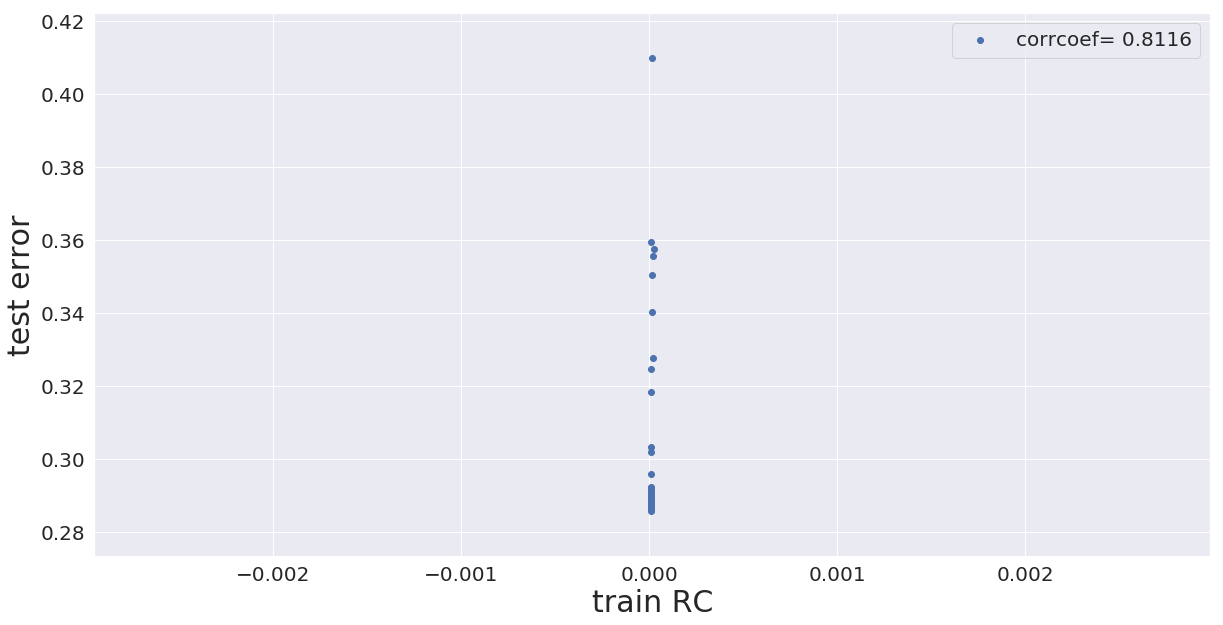

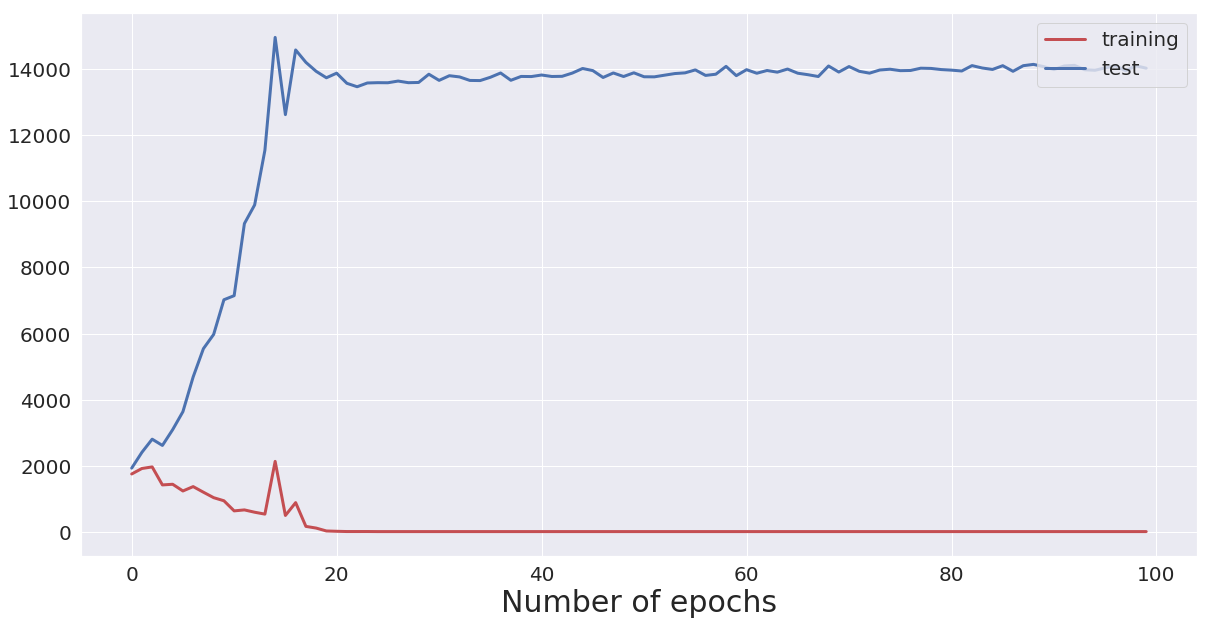

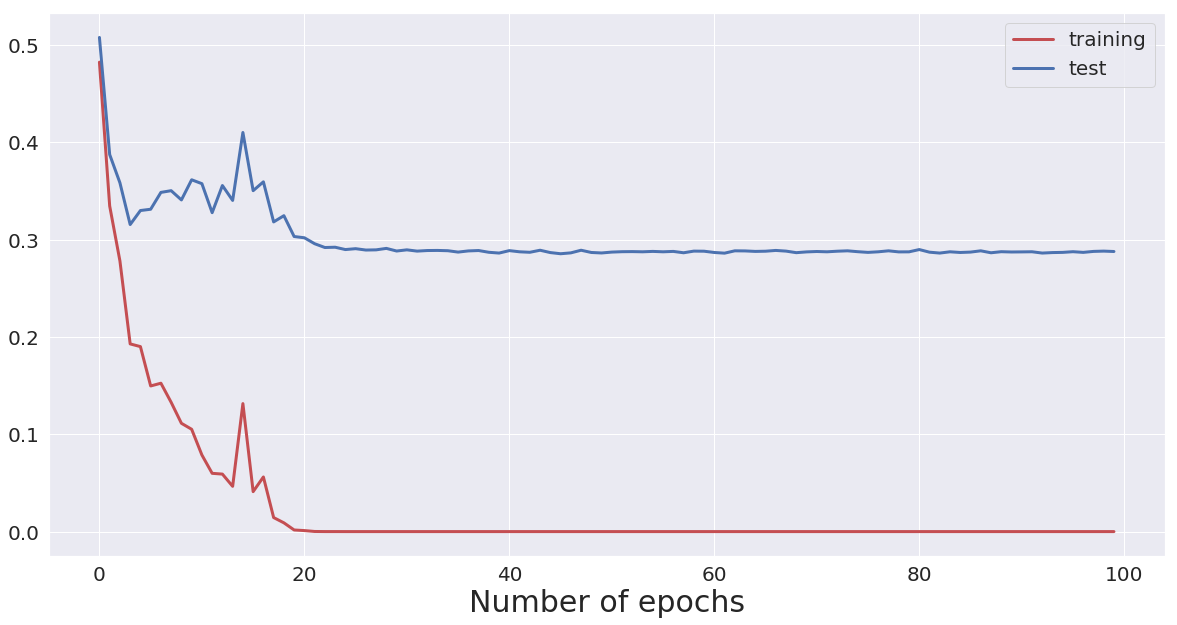

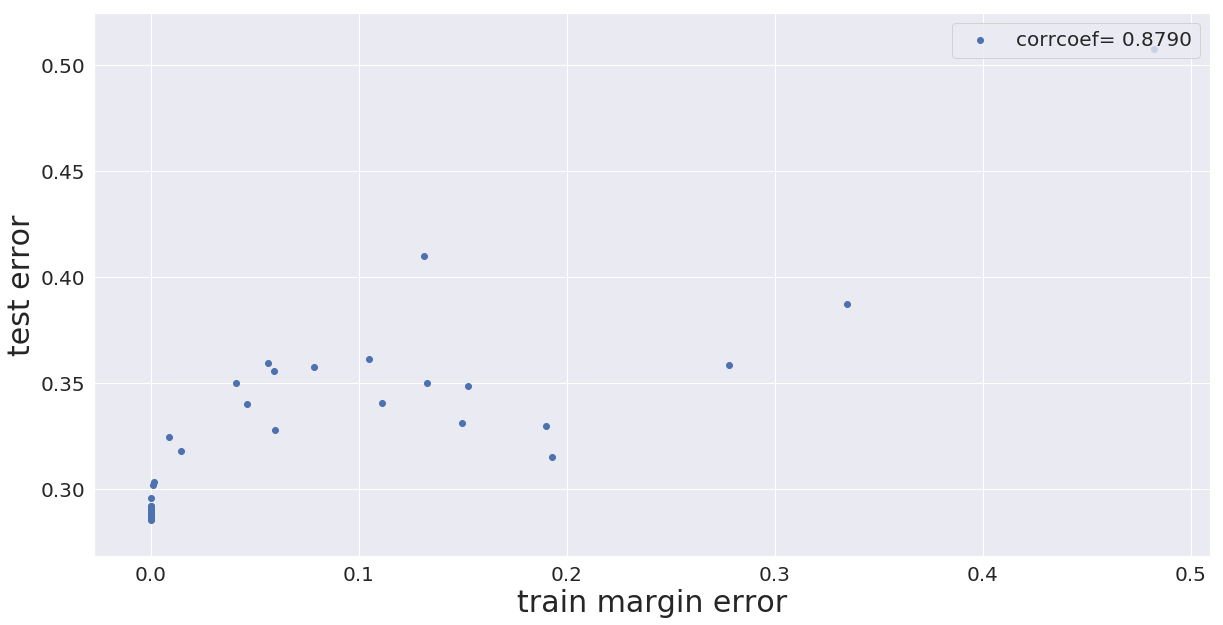

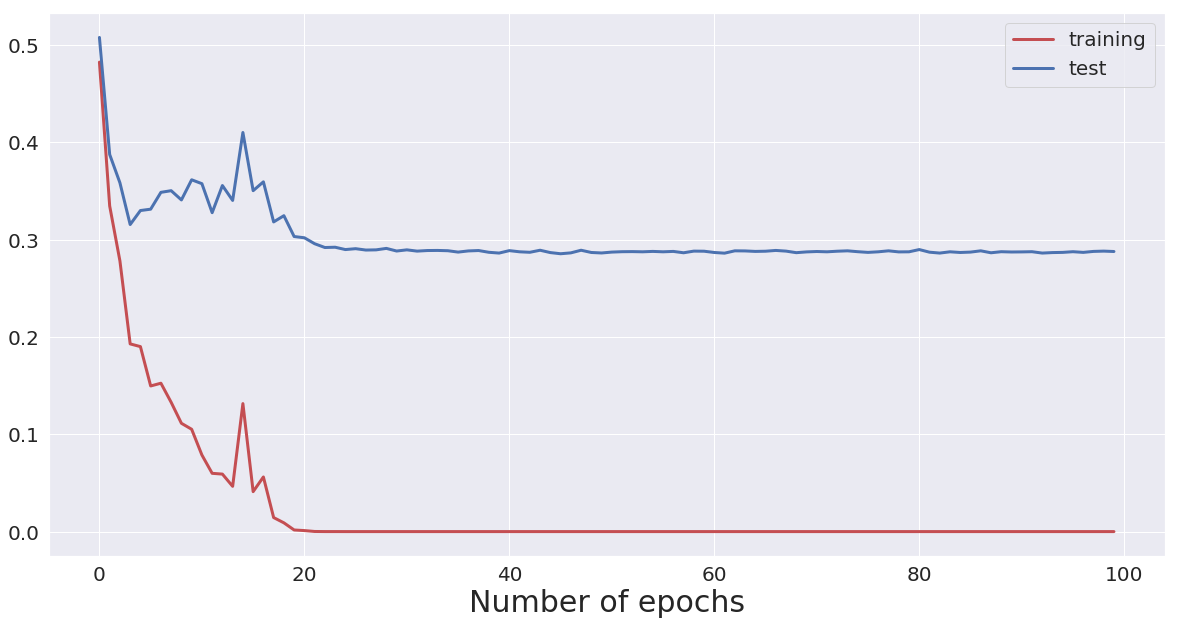

In [29]:
plot(log_1, 0.8, './vgg16_results_p0.1/')
plt.show()

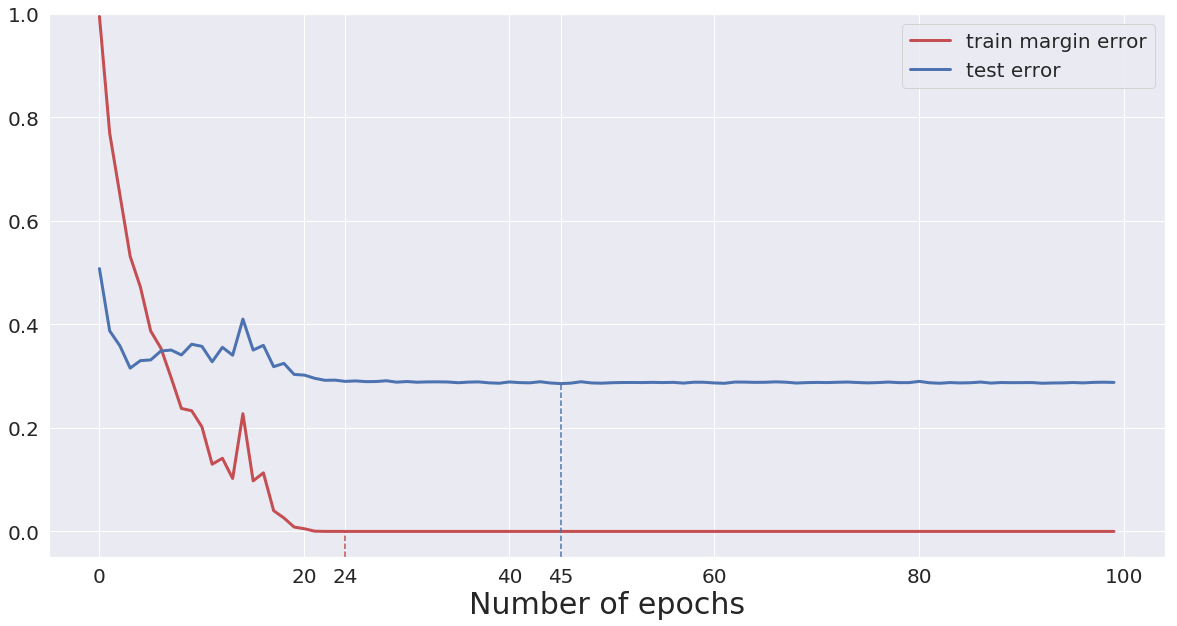

In [30]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 1e4) for (margin, lip) in zip(log_1['margin_train'], log_1['Lip'])]
ax.plot(train_merror
    ,'r',linewidth=3,
    label='train margin error')
ax.plot(log_1['test_error'],'b',linewidth=3,label='test error')
ax.legend(fontsize=20,loc='best')
#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
x1=np.argmin(log_1['test_error'])
ax.plot([x1,x1],[-0.05,log_1['test_error'][x1]],'b--')
x2=np.argmin(train_merror)
ax.plot([x2,x2],[-0.05,train_merror[x2]],'r--')
ax.set_xticks([0,min(x1,x2),max(x1,x2),20,40,60,80,100])
ax.set_xlabel('Number of epochs',fontdict={'size': 30})
fig.savefig('./vgg16_results_p0.1/margin_error_and_test_error.png')

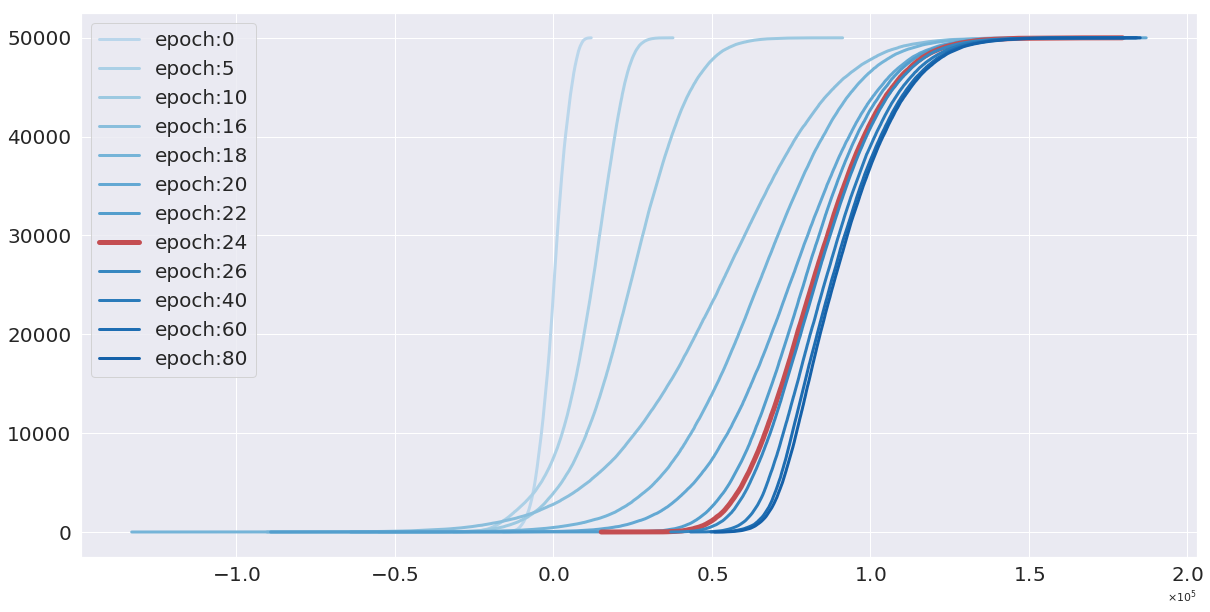

In [31]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,16,18,20,22,24,26,40,60, 80]):
    if i==24:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_1['margin_train'][i])/log_1['Lip'][i], range(50000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./vgg16_results_p0.1/'+'nMargin_distribution.png')

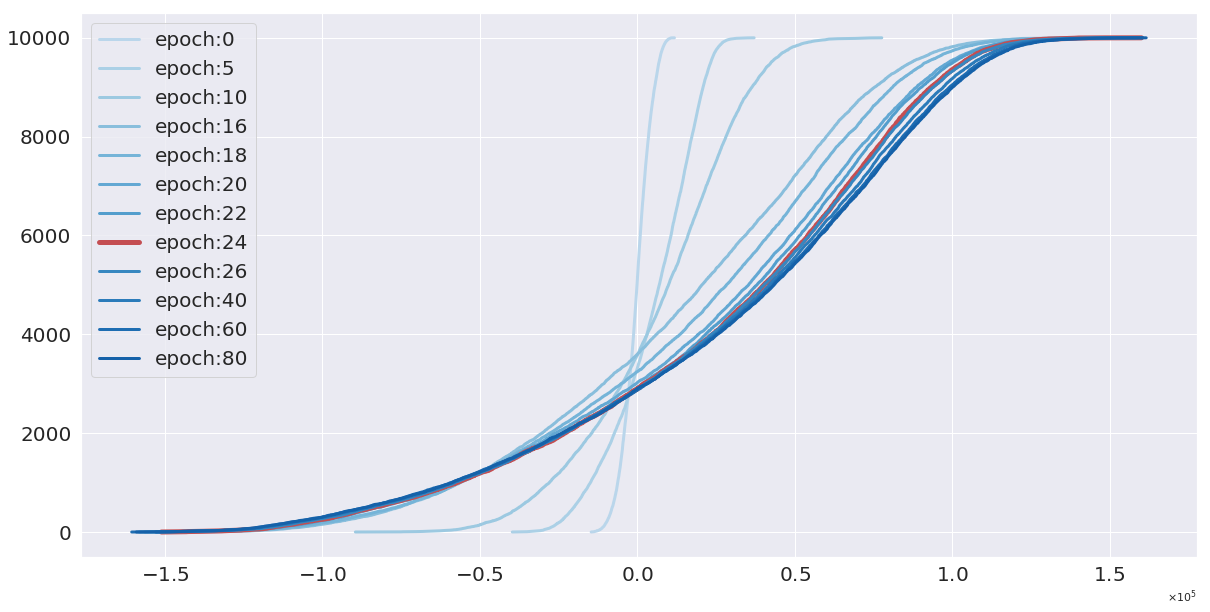

In [32]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,16,18,20,22,24,26,40,60, 80]):
    if i==24:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_1['margin_test'][i])/log_1['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./vgg16_results_p0.1/'+'test_nMargin_distribution.png')

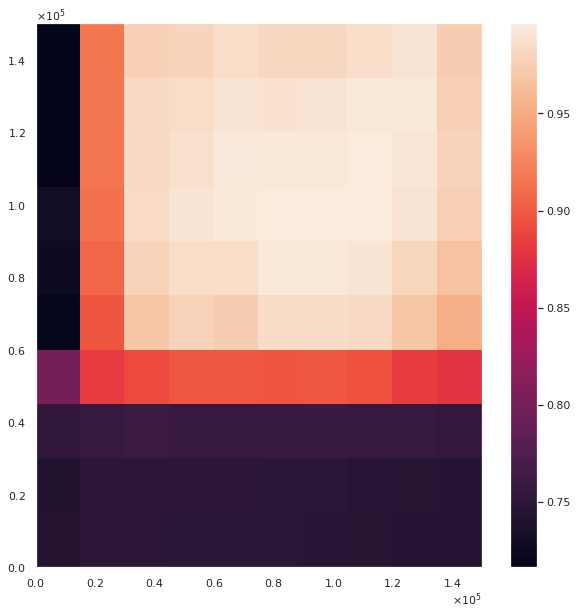

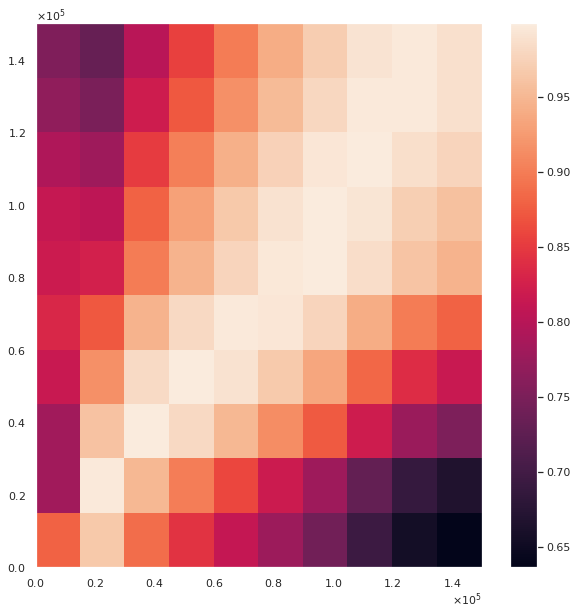

In [34]:
plot_heatmap(log_1,'./vgg16_results_p0.1/',np.linspace(0,1.5e5,11))

# Experiment on Cifar100 with noise=0.1 for VGG16

In [3]:
#
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms,'cifar100')

loaders = {'train': training_loader, 'test': testing_loader}

log_cifar100 = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
model = vgg.VGG('VGG16',num_classes=100)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_cifar100['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 14774436


In [4]:
model, log_cifar100 = train_model(
    model, criterion, optimizer, log_cifar100, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 3.4598 rLoss: 711.9746 Error: 0.8126 RampLoss: 0.812720 MarginError: 0.8129 Margin: -8.1650 Lip: 1.5650e-03
test Loss: 3.5291 rLoss: 744.6592 Error: 0.8301 RampLoss: 0.830349 MarginError: 0.8305 Margin: -7.9640 Lip: 1.5650e-03
Saving..
Epoch 2/100
----------
train1 Loss: 2.9347 rLoss: 1004.4624 Error: 0.7126 RampLoss: 0.712839 MarginError: 0.7130 Margin: -7.8967 Lip: 1.0954e-03
test Loss: 3.0953 rLoss: 1134.5903 Error: 0.7464 RampLoss: 0.746562 MarginError: 0.7468 Margin: -7.3034 Lip: 1.0954e-03
Epoch 3/100
----------
train1 Loss: 2.5442 rLoss: 1092.8185 Error: 0.6273 RampLoss: 0.627380 MarginError: 0.6275 Margin: -8.5969 Lip: 9.2418e-04
test Loss: 2.8063 rLoss: 1322.9471 Error: 0.6904 RampLoss: 0.690400 MarginError: 0.6904 Margin: -10.6328 Lip: 9.2418e-04
Epoch 4/100
----------
train1 Loss: 2.2566 rLoss: 1214.8780 Error: 0.5624 RampLoss: 0.562382 MarginError: 0.5624 Margin: -8.6355 Lip: 8.0030e-04
test Loss: 2.6848 rLoss: 1661.7023 Error: 0.6587 Ram

In [1]:
import pickle
log_cifar100=pickle.load(open('./vgg16_results_p0.1/log_cifar100','rb'))

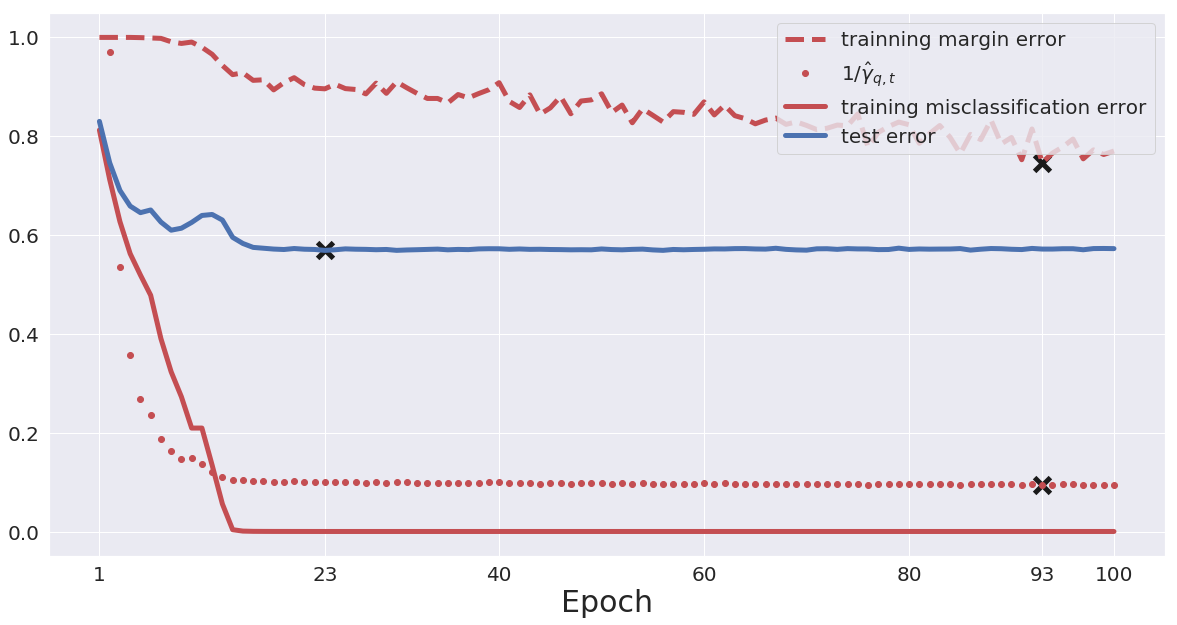

In [26]:
def get_qmargin(margins, q):
    q1 = int(len(margins[0]) * q)
    return [np.partition(margin, q1)[q1] for margin in margins]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 1e4) for (margin, lip) in zip(log_cifar100['margin_train'], log_cifar100['Lip'])]
nqMargin_train = np.array(get_qmargin(log_cifar100['margin_train'],
                                                 0.9)) / np.array(log_cifar100['Lip'])*1e-3

ax.plot(train_merror
    ,'r--',linewidth=5,
    label='trainning margin error')
ax.plot(1/nqMargin_train,'ro', linewidth=5, label=r'$1/\hat{\gamma}_{q,t}$')

ax.plot(log_cifar100['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log_cifar100['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1.05)
x1=np.argmin(log_cifar100['test_error'])
ax.scatter(x1,log_cifar100['test_error'][x1],s=250,c='k',marker='x',linewidth=5)
x2=np.argmin(train_merror)
ax.scatter(x2,train_merror[x2],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
#fig.savefig('./results_original/margin_error_and_test_error.png')


x3=np.argmin(1/nqMargin_train)
ax.scatter(x3,1/nqMargin_train[x3],s=250,c='k',marker='x',linewidth=5)
ax.set_xticks([0,x1,x2,x3,39,59,79,99])
ax.set_xticklabels([1,x1+1,'',x3+1,40,60,80,100])
ax.legend(loc='best',fontsize=20)
#plt.show()
fig.savefig('./vgg16_results_p0.1/cifar100_margin_error_and_test_error.png')

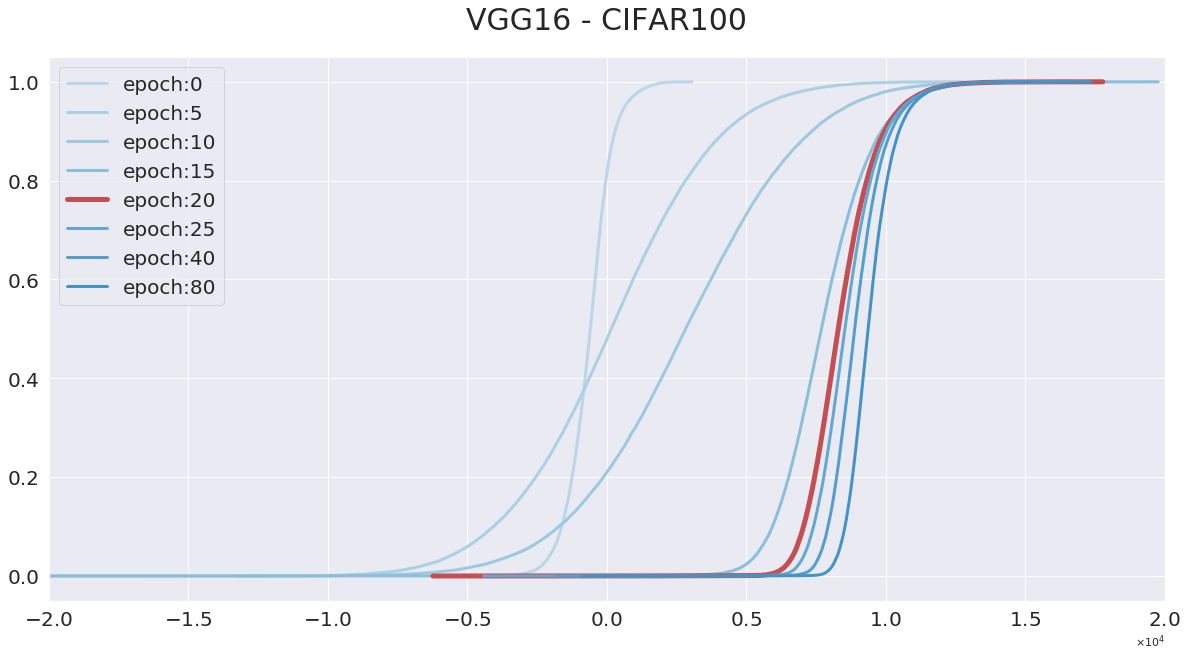

In [48]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('VGG16 - CIFAR100', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,15,20,25, 40, 80]):
    if i==20:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_cifar100['margin_train'][i])/log_cifar100['Lip'][i], np.arange(50000)/50000,c=c, label=f'epoch:{i}',linewidth=d)
ax.set_xlim([-2e4, 2e4])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./vgg16_results_p0.1/'+'cifar100_nMargin_distribution.png')

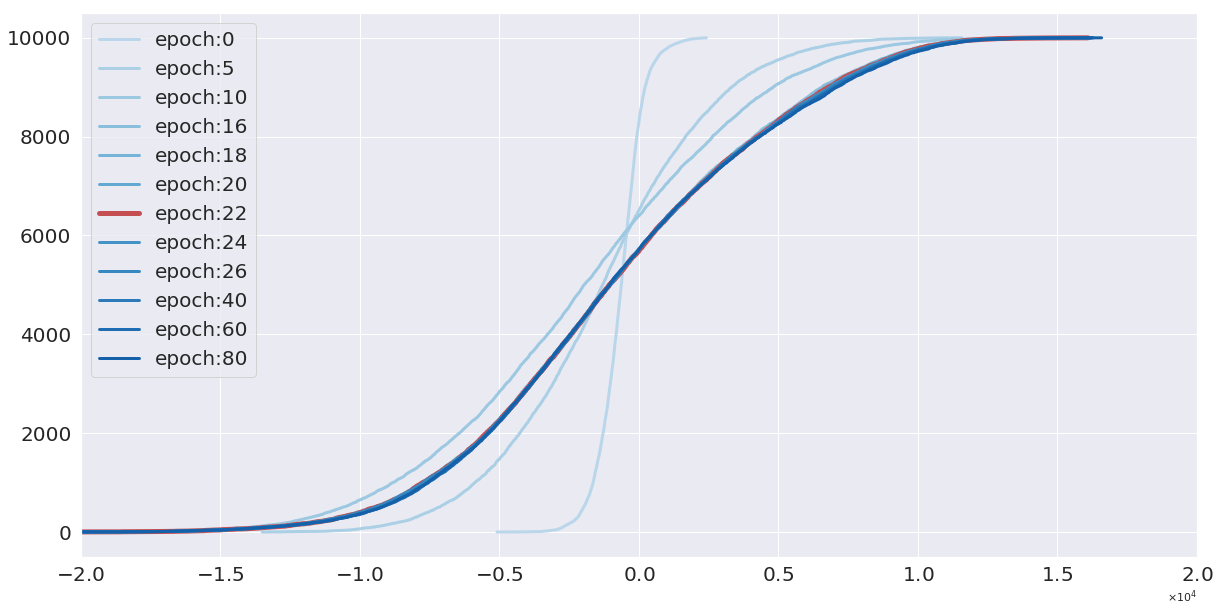

In [16]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,16,18,20,22,24,26,40,60, 80]):
    if i==22:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_cifar100['margin_test'][i])/log_cifar100['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
ax.set_xlim([-2e4, 2e4])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./vgg16_results_p0.1/'+'cifar100_test_nMargin_distribution.png')

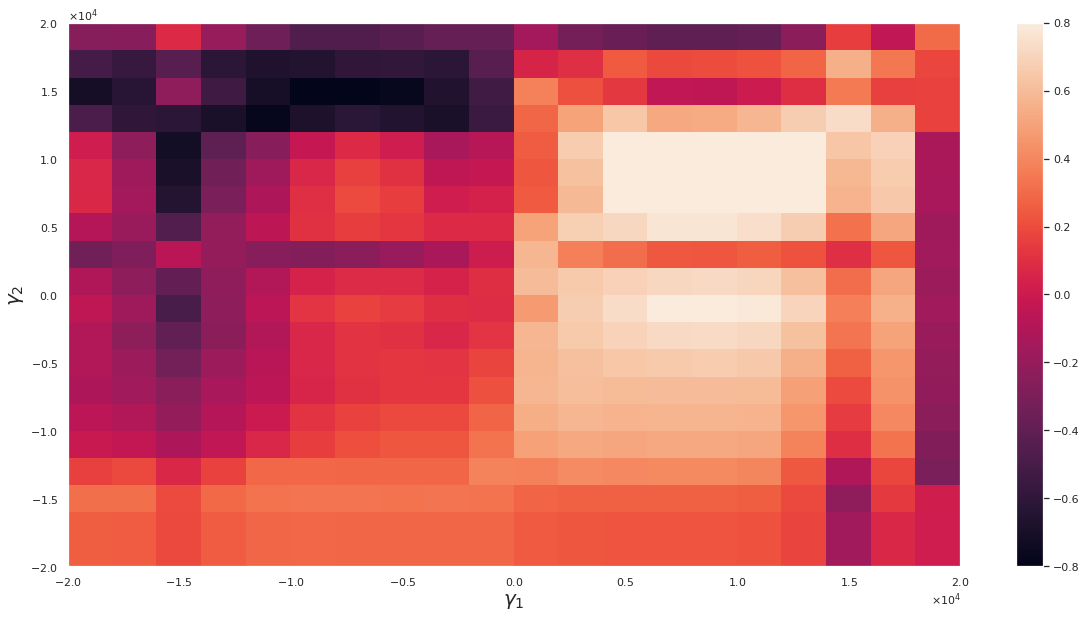

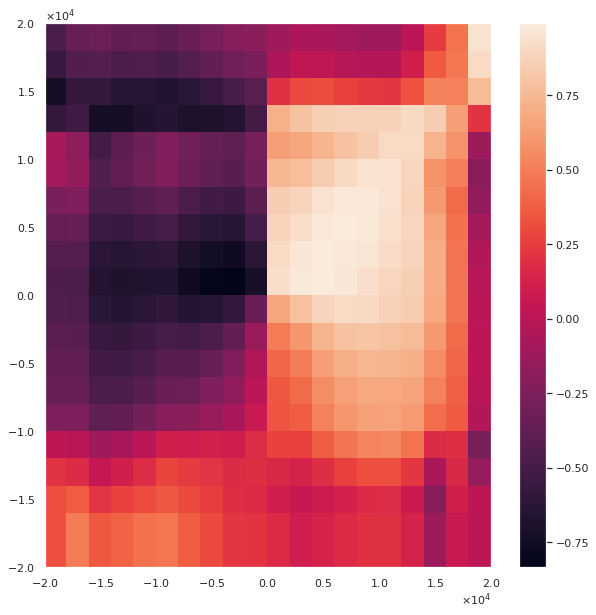

In [45]:
plot_heatmap(log_cifar100,'./vgg16_results_p0.1/cifar100_',np.linspace(-2e4,2e4,21))

In [20]:
import pickle
pickle.dump(log_cifar100,open('./vgg16_results_p0.1/log_cifar100','wb'))

# Experiment on MiniImageNet with noise=0.1 for VGG16

In [3]:
#
root = '/home/share/DataSets/data_miniImageNet.h5'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
3(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms,'miniImageNet')

loaders = {'train': training_loader, 'test': testing_loader}

log_mini = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 600
model = vgg.VGG('VGG16',num_classes=100)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_mini['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 14774436


In [4]:
model, log_mini = train_model(
    model, criterion, optimizer, log_mini, g0, num_epochs=num_epochs)

Epoch 1/600
----------
train1 Loss: 4.0799 rLoss: 914.9951 Error: 0.9074 RampLoss: 0.907527 MarginError: 0.9077 Margin: -9.7165 Lip: 1.4167e-03
test Loss: 4.1058 rLoss: 925.7499 Error: 0.9085 RampLoss: 0.908674 MarginError: 0.9088 Margin: -7.6575 Lip: 1.4167e-03
Saving..
Epoch 2/600
----------
train1 Loss: 3.8456 rLoss: 1358.8480 Error: 0.8702 RampLoss: 0.870249 MarginError: 0.8704 Margin: -12.7671 Lip: 1.0873e-03
test Loss: 3.8580 rLoss: 1369.3736 Error: 0.8688 RampLoss: 0.868800 MarginError: 0.8688 Margin: -9.9886 Lip: 1.0873e-03
Epoch 3/600
----------
train1 Loss: 3.7797 rLoss: 1932.6798 Error: 0.8526 RampLoss: 0.852622 MarginError: 0.8527 Margin: -13.2434 Lip: 8.4189e-04
test Loss: 3.8038 rLoss: 1952.4037 Error: 0.8534 RampLoss: 0.853527 MarginError: 0.8536 Margin: -10.6781 Lip: 8.4189e-04
Epoch 4/600
----------
train1 Loss: 3.6079 rLoss: 2193.1892 Error: 0.8240 RampLoss: 0.824088 MarginError: 0.8242 Margin: -10.5064 Lip: 7.0064e-04
test Loss: 3.6517 rLoss: 2246.4611 Error: 0.8332 

In [27]:
import pickle
log_mini=pickle.load(open('./vgg16_results_p0.1/log_mini','rb'))

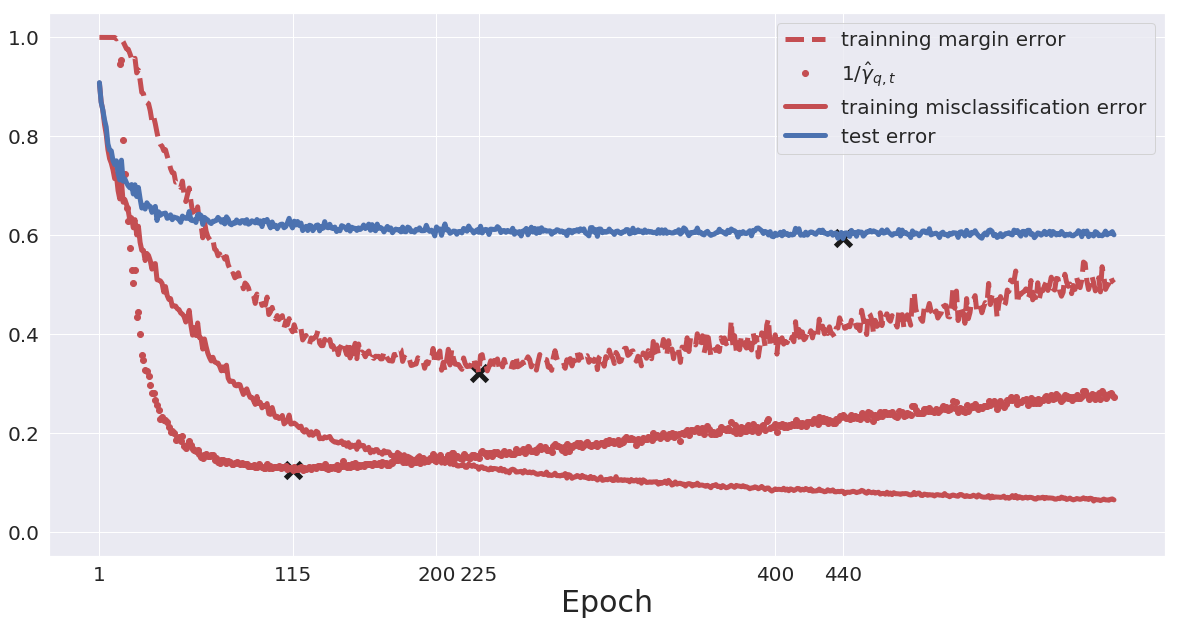

In [40]:
def get_qmargin(margins, q):
    q1 = int(len(margins[0]) * q)
    return [np.partition(margin, q1)[q1] for margin in margins]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip *0.2e5) for (margin, lip) in zip(log_mini['margin_train'], log_mini['Lip'])]
nqMargin_train = np.array(get_qmargin(log_mini['margin_train'],
                                                 0.95)) / np.array(log_mini['Lip'])*1e-4

ax.plot(train_merror
    ,'r--',linewidth=5,
    label='trainning margin error')
ax.plot(1/nqMargin_train,'ro', linewidth=5, label=r'$1/\hat{\gamma}_{q,t}$')

ax.plot(log_mini['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log_mini['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1.05)
x1=np.argmin(log_mini['test_error'])
ax.scatter(x1,log_mini['test_error'][x1],s=250,c='k',marker='x',linewidth=5)
x2=np.argmin(train_merror)
ax.scatter(x2,train_merror[x2],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
#fig.savefig('./results_original/margin_error_and_test_error.png')


x3=np.argmin(1/nqMargin_train)
ax.scatter(x3,1/nqMargin_train[x3],s=250,c='k',marker='x',linewidth=5)
ax.set_xticks([0,x1,x2,x3,199,399])
ax.set_xticklabels([1,x1+1,x2+1,x3+1,200,400])
ax.legend(loc='best',fontsize=20)
#plt.show()
fig.savefig('./vgg16_results_p0.1/mini_margin_error_and_test_error.png')

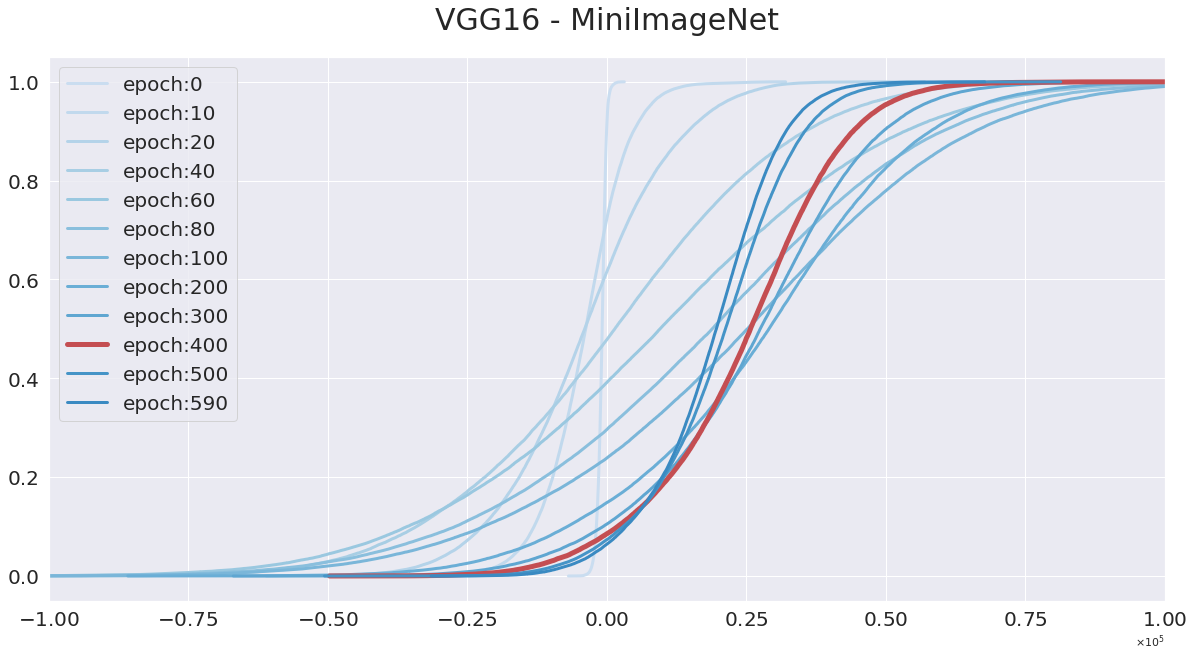

In [49]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('VGG16 - MiniImageNet', fontsize=30, y=1.04)

#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0,10,20,40,60,80,100,200,300,400,500,590]):
    if i==400:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',25)[j+5]
        d=3
    ax.plot(np.sort(log_mini['margin_train'][i])/log_mini['Lip'][i], np.arange(50000)/50000,c=c, label=f'epoch:{i}',linewidth=d)
ax.set_xlim([-1e5, 1e5])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./vgg16_results_p0.1/'+'mini_nMargin_distribution.png')

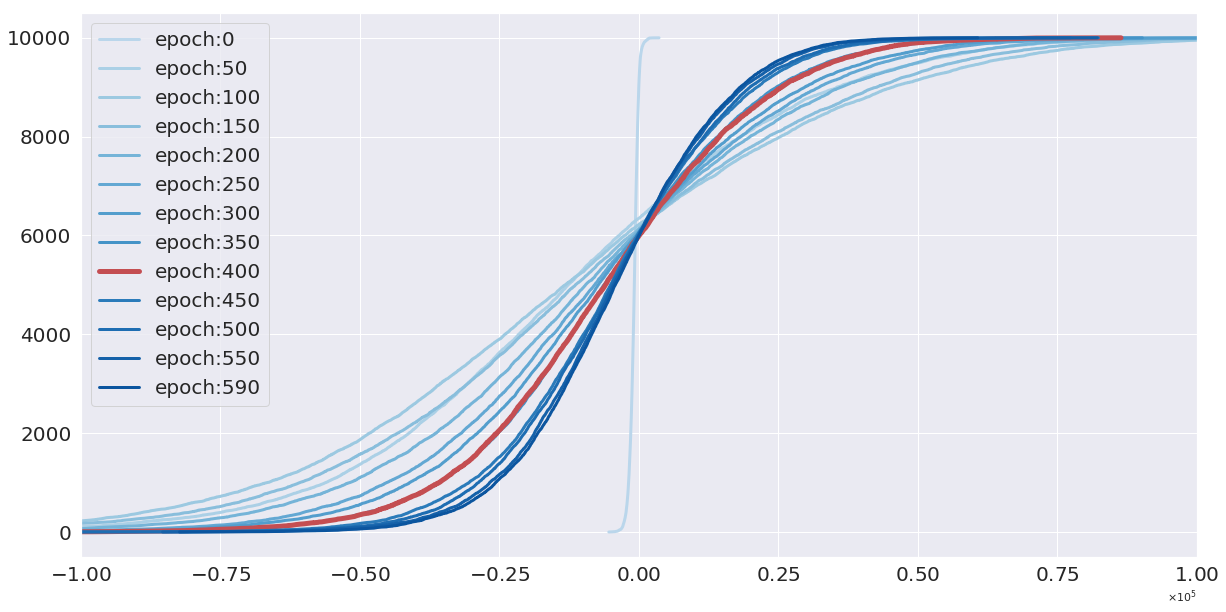

In [8]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 50,100,150,200,250,300,350,400,450,500,550,590]):
    if i==400:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_mini['margin_test'][i])/log_mini['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
ax.set_xlim([-1e5, 1e5])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./vgg16_results_p0.1/'+'mini_test_nMargin_distribution.png')

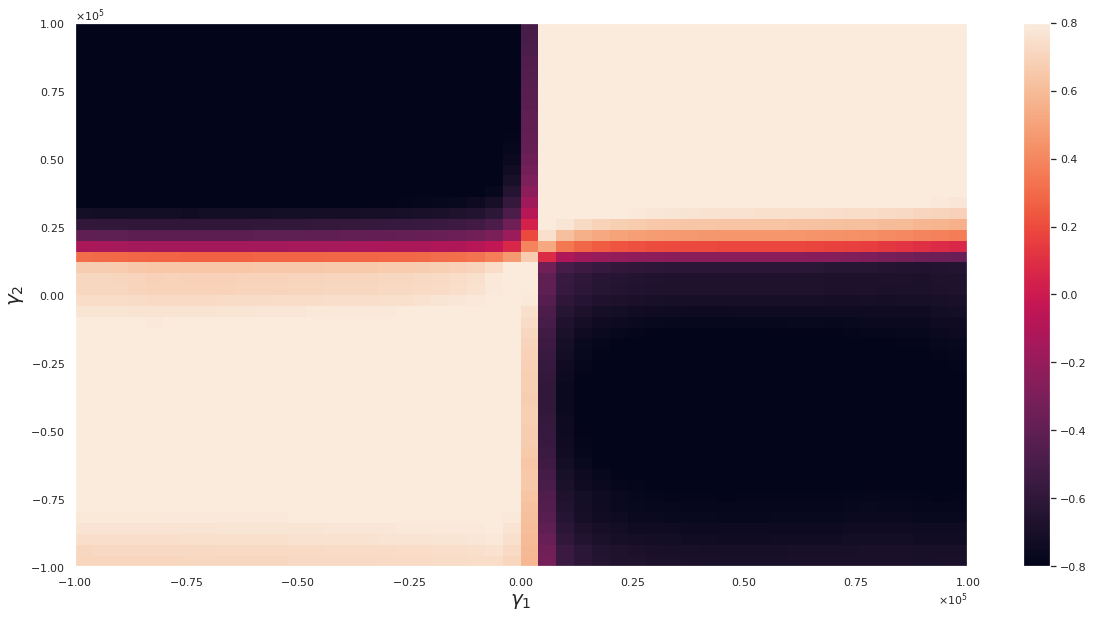

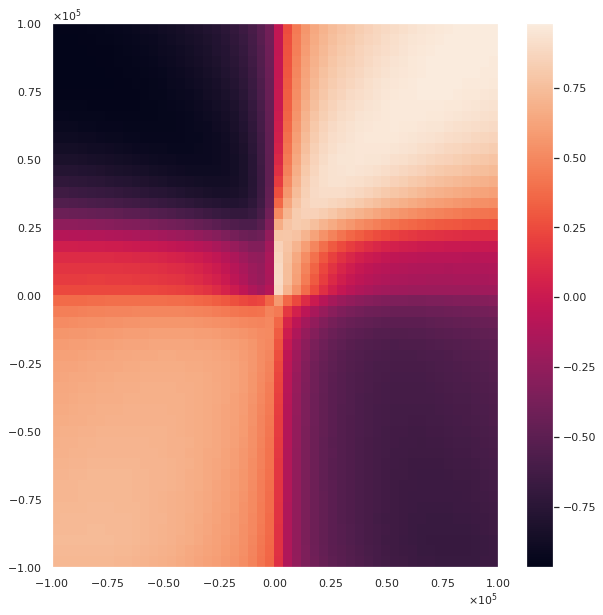

In [46]:
plot_heatmap(log_mini,'./vgg16_results_p0.1/mini_',np.linspace(-1e5,1e5,51))

In [12]:
import pickle
pickle.dump(log_mini,open('./vgg16_results_p0.1/log_mini','wb'))